This notebook is split into two sections. The first part includes the code that finds the optimal combination of (T,K) and in the second part I train the models. The whole pipeline including both sections is run at the very end where you can see every step

Libraries

In [1]:
import torch
import gpytorch

print("PyTorch Version:", torch.__version__)
print("CUDA Available (GPU):", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU only.")

PyTorch Version: 2.6.0+cu124
CUDA Available (GPU): False
Running on CPU only.


In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel, AdditiveKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, r2_score, mean_squared_error,
                            silhouette_score, davies_bouldin_score, calinski_harabasz_score)
from scipy.stats import f_oneway
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
def setup_environment(seed=42, data_dir=r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper"):

    os.chdir(data_dir)
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    if device == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")
        torch.cuda.empty_cache()
    
    return device

DATA LOADING AND PROCESSING

In [4]:
def load_wind_data(filepath):

    print(f"Loading wind data from {filepath}")
    
    df = pd.read_csv(filepath)
    df.rename(columns={'Unnamed: 0': 'ID', 'time': 'Time'}, inplace=True)

    initial_len = len(df)
    df = df[df['Turn_off'] != 0].copy()
    turn_off_removed = initial_len - len(df)
    print(f"  Removed {turn_off_removed} hours where farm was turned off ({100*turn_off_removed/initial_len:.1f}%)")
    
    df['Power'] = pd.to_numeric(df['Power'], errors='coerce')
    power_null = df['Power'].isnull().sum()
    df = df.dropna(subset=['Power'])

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.dropna(subset=['Time'])
    df['Month'] = df['Time'].dt.month
    df['Hour'] = df['Time'].dt.hour
    df = df[(df['Time'] >= '2018-01-01') & (df['Time'] <= '2020-01-01')]

    for lag in [1, 2, 3]:
        df[f'Power_t-{lag}'] = df['Power'].shift(lag)
        df[f'Windspeed_t-{lag}'] = df['Windspeed'].shift(lag)

    df = df.dropna(subset=[f'Power_t-1', f'Power_t-2', f'Power_t-3'])

    print(f"  Loaded: {len(df)} hours")
    print(f"  Power range: {df['Power'].min():.1f} - {df['Power'].max():.1f} MW")
    print(f"  Power mean: {df['Power'].mean():.1f} MW ± {df['Power'].std():.1f} MW")
    print(f"  Null values removed: {power_null}")
    print(f"  Turn-off periods removed: {turn_off_removed}")
 
    return df

In [ ]:
df_Beatrice = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Beatrice.csv")
df_Hornsea = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Hornsea_(Project_1).csv")
df_Walney = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Walney.csv")
df_Gode = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Gode_Wind.csv")
df_Baltic = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Baltic_Eagle.csv")
df_Iles = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Iles_dYeu_et_de_Noirmoutir.csv")

# Drop columns from each dataframe
df_Beatrice = df_Beatrice.drop(columns=['Scaled_Windspeed_(at_90m)', 'Power_of_SWT-7.0-154'])
df_Hornsea = df_Hornsea.drop(columns=['Scaled_Windspeed_(at_113m)', 'Power_of_SWT-7.0-154'])
df_Walney = df_Walney.drop(columns=['Scaled_Windspeed_(at_113m)', 'Scaled_Windspeed_(at_111m)', 'Power_of_V164-8.0', 'Power_of_SWT-7.0-154'])
df_Gode = df_Gode.drop(columns=['Scaled_Windspeed_(at_100m)', 'Power_of_SWT-6.0-154'])
df_Baltic = df_Baltic.drop(columns=['Scaled_Windspeed_(at_107m)', 'Power_of_V174-9.5'])
df_Iles = df_Iles.drop(columns=['Scaled_Windspeed_(at_100m)', 'Power_of_SG 8.0-167 DD'])

# Then add farm_id
df_Beatrice['farm_id'] = 'Beatrice'
df_Hornsea['farm_id'] = 'Hornsea'
df_Walney['farm_id'] = 'Walney'
df_Gode['farm_id'] = 'Gode'
df_Baltic['farm_id'] = 'Baltic'
df_Iles['farm_id'] = 'Iles'

# Concatenate all dataframes
df = pd.concat([df_Beatrice, df_Hornsea, df_Walney, df_Gode, df_Baltic, df_Iles], axis=0, ignore_index=True)

print(f"Combined shape: {df.shape}")

Loading wind data from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Beatrice.csv
  Removed 252 hours where farm was turned off (0.1%)
  Loaded: 17512 hours
  Power range: 0.0 - 588.0 MW
  Power mean: 291.5 MW ± 221.7 MW
  Null values removed: 0
  Turn-off periods removed: 252
Loading wind data from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Hornsea_(Project_1).csv
  Removed 549 hours where farm was turned off (0.2%)
  Loaded: 17508 hours
  Power range: 0.0 - 1218.0 MW
  Power mean: 665.5 MW ± 458.2 MW
  Null values removed: 0
  Turn-off periods removed: 549
Loading wind data from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Walney.csv
  Removed 661 hours where farm was turned off (0.2%)
  Loaded: 17502 hours
  Power range: 0.0 - 649.0 MW
  Power mean: 346.2 MW ± 253.7 MW
  Null values removed: 0
  Turn-off periods removed: 661
Loading wind data from C:\Users\dweis\OneDrive\Documen

EXTRACT TIMESERIES MATRIX

In [6]:
def extract_timeseries(df, time_period_hours=24):
    
    n_periods = len(df) // time_period_hours
    timeseries_list = []
    period_info = []
    
    all_features = [    
        'Power', 'Windspeed', 'Wind_Direction', 'fsr', 'Hour', 'u100', 'v100', 'Month', 
        'Power_t-1', 'Power_t-2', 'Power_t-3', 'Windspeed_t-1', 'Windspeed_t-2', 'Windspeed_t-3']
    
    vae_features = ['Windspeed', 'fsr', 'Wind_Direction', 'u100', 'v100']
    
    df['time_diff'] = df['Time'].diff().dt.total_seconds() / 3600
    df['is_continuous'] = df['time_diff'] <= 1.5
    df.loc[df.index[0], 'is_continuous'] = True
    
    skipped = 0
    
    for i in range(n_periods):
        start_idx = i * time_period_hours
        end_idx = start_idx + time_period_hours
        
        if end_idx > len(df):
            continue
        
        if not df['is_continuous'].iloc[start_idx:end_idx].all():
            skipped += 1
            continue
        
        period_data_full = []
        period_data_vae = []
        
        for feature in all_features:
            if feature in ['Hour', 'Month', 'Wind_Direction']:
                continue
            if feature in df.columns:
                feature_values = df[feature].iloc[start_idx:end_idx].values
                period_data_full.append(feature_values)
                if feature in vae_features:
                    period_data_vae.append(feature_values)
            else:
                period_data_full.append(np.zeros(time_period_hours))
        
        # Cyclical features
        for col, max_val in [('Hour', 24), ('Wind_Direction', 360), ('Month', 12)]:
            vals = df[col].iloc[start_idx:end_idx].values
            sin_vals = np.sin(2 * np.pi * vals / max_val)
            cos_vals = np.cos(2 * np.pi * vals / max_val)
            period_data_full.extend([sin_vals, cos_vals])
            if col == 'Wind_Direction':
                period_data_vae.extend([sin_vals, cos_vals])
        
        period_power = df['Power'].iloc[start_idx:end_idx].values
        period_wind = df['Windspeed'].iloc[start_idx:end_idx].values
        farm_id = df['farm_id'].iloc[start_idx] if 'farm_id' in df.columns else 'Unknown'
        
        timeseries_list.append({
            'full': np.array(period_data_full),
            'vae': np.array(period_data_vae)
        })
        
        period_info.append({
            'period_id': i,
            'start_time': df['Time'].iloc[start_idx],
            'mean_power': np.nanmean(period_power),
            'std_power': np.nanstd(period_power),
            'mean_wind': np.nanmean(period_wind),
            'std_wind': np.nanstd(period_wind),
            'month': df['Month'].iloc[start_idx],
            'farm_id': farm_id
        })
    
    timeseries_matrix_full = np.array([item['full'] for item in timeseries_list])
    timeseries_matrix_vae = np.array([item['vae'] for item in timeseries_list])
    
    print(f"Extracted: {len(timeseries_list)} periods (skipped {skipped} discontinuous)")
    print(f"Full: {timeseries_matrix_full.shape}, VAE: {timeseries_matrix_vae.shape}")
    
    return timeseries_matrix_full, timeseries_matrix_vae, period_info

SPLITTING INTO TRAIN/TEST

In [7]:
def split_timeperiods(timeseries_matrix, period_info, test_ratio=0.2, random_state=42):
    
    n_periods = len(timeseries_matrix)
    np.random.seed(random_state)
    all_indices = np.arange(n_periods)
    np.random.shuffle(all_indices)
    
    split_point = int((1 - test_ratio) * n_periods)
    train_indices = sorted(all_indices[:split_point])
    test_indices = sorted(all_indices[split_point:])
    
    train_timeseries = timeseries_matrix[train_indices]
    test_timeseries = timeseries_matrix[test_indices]
    train_period_info = [period_info[i] for i in train_indices]
    test_period_info = [period_info[i] for i in test_indices]
    train_farm_ids = np.array([info['farm_id'] for info in train_period_info])
    test_farm_ids = np.array([info['farm_id'] for info in test_period_info])
    
    print(f"Timeseries randomly split into {len(train_indices)} train periods and {len(test_indices)} test periods")
    
    return {
        'train_timeseries': train_timeseries,
        'test_timeseries': test_timeseries,
        'train_period_info': train_period_info,
        'test_period_info': test_period_info,
        'train_indices': train_indices,
        'test_indices': test_indices,
        'train_farm_ids': train_farm_ids,  
        'test_farm_ids': test_farm_ids     
    }

NORMALISING

In [8]:
def normalise_timeseries(train_timeseries, test_timeseries, feature_names, log_features=['fsr']):
    
    scalers = {}
    log_transforms = {}  
    train_normalised = train_timeseries.copy().astype(np.float32)
    test_normalised = test_timeseries.copy().astype(np.float32)

    cyclical_features = ['sin', 'cos']
    
    for ch in range(train_timeseries.shape[1]):
        channel_name = feature_names[ch] if ch < len(feature_names) else f'Channel_{ch}'
        
        if any(cyc in channel_name for cyc in cyclical_features):
            continue
        
        train_channel_data = train_timeseries[:, ch, :].flatten()
        test_channel_data = test_timeseries[:, ch, :].flatten()
        
        if channel_name in log_features:
            train_channel_data = np.log(train_channel_data)
            test_channel_data = np.log(test_channel_data)
            log_transforms[channel_name] = True
        else:
            log_transforms[channel_name] = False
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(train_channel_data.reshape(-1, 1))
        
        train_scaled = scaler.transform(train_channel_data.reshape(-1, 1)).flatten()
        train_normalised[:, ch, :] = train_scaled.reshape(train_timeseries.shape[0], -1)
        
        test_scaled = scaler.transform(test_channel_data.reshape(-1, 1)).flatten()
        test_normalised[:, ch, :] = test_scaled.reshape(test_timeseries.shape[0], -1)
        
        scalers[channel_name] = scaler
    
    return train_normalised, test_normalised, scalers, log_transforms

VAE SET-UP

In [9]:
class TimeSeriesVAE(nn.Module):
    def __init__(self, input_dim=6, sequence_length=24, latent_dim=8, hidden_dim=128):
        super(TimeSeriesVAE, self).__init__()
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        self.encoder_lstm = nn.LSTM(128, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.encoder_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.decoder_lstm = nn.LSTM(hidden_dim, 128, batch_first=True)
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, input_dim, kernel_size=5, padding=2)
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv1d, nn.ConvTranspose1d)):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                module.bias.data.zero_()
    
    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.permute(0, 2, 1)
        h, _ = self.encoder_lstm(h)
        h = h[:, -1, :]
        h = self.encoder_fc(h)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.unsqueeze(1).repeat(1, self.sequence_length, 1)
        h, _ = self.decoder_lstm(h)
        h = h.permute(0, 2, 1)
        return self.decoder_conv(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

In [10]:
class WindPowerDataset(Dataset):
    def __init__(self, timeseries_matrix):
        self.data = timeseries_matrix.astype(np.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx])

In [11]:
def vae_loss_function(recon_x, x, mu, logvar, beta=0.5):

    recon_loss = nn.MSELoss(reduction='mean')(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = torch.clamp(kl_loss, max=1000.0)
    kl_loss /= x.size(0) * x.size(1) * x.size(2)
    total_loss = recon_loss + beta * kl_loss 
    
    return total_loss, recon_loss, kl_loss

TRAIN VAE

In [36]:
def train_vae(train_normalised_vae, latent_dim=8, epochs=200, batch_size=64, vae_save_path=None, device='cuda'):

    if vae_save_path and os.path.exists(vae_save_path):
        vae = TimeSeriesVAE(train_normalised_vae.shape[1], 
                           train_normalised_vae.shape[2], latent_dim).to(device)
        vae.load_state_dict(torch.load(vae_save_path, map_location=device))
        vae.eval()
        print(f"VAE loaded from {vae_save_path}")
        return vae
    
    print(f"Training VAE (latent_dim={latent_dim}, epochs={epochs})")
    vae = TimeSeriesVAE(train_normalised_vae.shape[1], train_normalised_vae.shape[2], latent_dim).to(device)

    dataset = WindPowerDataset(train_normalised_vae)

    def seed_worker(worker_id):
            worker_seed = torch.initial_seed() % 2**32
            np.random.seed(worker_seed)
            random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(42)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)
    optimizer = optim.AdamW(vae.parameters(), lr=3e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    vae.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0
        
        beta = min(1.0, 0.01 + (epoch / (epochs * 0.5)) * 0.99)         
        
        for batch in dataloader:
            batch = batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            recon_batch, mu, logvar, z = vae(batch)
            total_loss, recon_loss, kl_loss = vae_loss_function(recon_batch, batch, mu, logvar, beta=beta)
            
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                continue
                
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            batch_count += 1
        
        if batch_count == 0:
            continue
            
        epoch_loss /= batch_count
        scheduler.step()
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter > 30:
            print(f"    Early stopping at epoch {epoch}")
            break
            
        if (epoch + 1) % 25 == 0:
            print(f"  Epoch {epoch+1:3d}: Loss={epoch_loss:.4f}, β={beta:.3f}")
    
    print(f"  VAE training completed! Best loss: {best_loss:.4f}")

    if vae_save_path is not None:
        torch.save(vae.state_dict(), vae_save_path)
        print(f"  VAE model saved to {vae_save_path}")

    return vae

EXTRACT VAE LATENT FEATURES

In [12]:
def extract_vae_features(vae, normalised_vae, device='cuda'):

    vae.eval()
    vae = vae.to(device)

    use_workers = 0 if device == 'cpu' else 4
    use_pin_memory = False if device == 'cpu' else True

    dataset = WindPowerDataset(normalised_vae)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=use_workers, pin_memory=use_pin_memory)
    latent_codes = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device, non_blocking=True)
            mu, logvar = vae.encode(batch)
            z = mu #vae.reparameterize(mu, logvar)
            latent_codes.append(z.cpu().numpy())
            
    latent_matrix = np.vstack(latent_codes)

    if device == 'cuda':
        torch.cuda.empty_cache()
    
    return latent_matrix

CLUSTER IN THE LATENT SPACE

In [13]:
def cluster_training_latent_space(train_latent_features, k_clusters=6):

    print(f"Clustering {train_latent_features.shape[0]} training periods into {k_clusters} clusters")
    
    train_latent_norm = normalize(train_latent_features, norm='l2')
    clustering_model = AgglomerativeClustering(n_clusters=k_clusters, linkage='ward', metric='euclidean')
    train_cluster_labels = clustering_model.fit_predict(train_latent_norm)
    
    unique_clusters, counts = np.unique(train_cluster_labels, return_counts=True)
    min_size = 10
    
    for cluster_id in list(unique_clusters):
        idx = np.where(unique_clusters == cluster_id)[0][0]
        if counts[idx] < min_size:
            small_mask = train_cluster_labels == cluster_id
            if np.sum(small_mask) == 0:
                continue
            small_centroid = np.mean(train_latent_norm[small_mask], axis=0)
            other_ids = unique_clusters[unique_clusters != cluster_id]
            other_centroids = [np.mean(train_latent_norm[train_cluster_labels == c], axis=0) for c in other_ids]
            distances = np.linalg.norm(np.array(other_centroids) - small_centroid, axis=1)
            nearest_cluster = other_ids[np.argmin(distances)]
            train_cluster_labels[small_mask] = nearest_cluster
            print(f"Merged small cluster {cluster_id} ({counts[idx]} samples) into {nearest_cluster}")
    
    unique_clusters, counts = np.unique(train_cluster_labels, return_counts=True)
    for cluster_id, size in zip(unique_clusters, counts):
        print(f"  Cluster {cluster_id}: {size} periods")
    
    return train_cluster_labels

ASSIGN CLUSTERS TO TEST SET 

In [14]:
def assign_test_clusters(train_latent_features, test_latent_features, train_cluster_labels):
    print(f"Assigning test periods to clusters")
    print(f"  Test latent features Shape: {test_latent_features.shape}")
    
    train_norm = normalize(train_latent_features, norm='l2')
    test_norm = normalize(test_latent_features, norm='l2')
    
    centroid_classifier = NearestCentroid(metric='euclidean')
    centroid_classifier.fit(train_norm, train_cluster_labels)
    test_cluster_labels = centroid_classifier.predict(test_norm)
    
    unique_clusters = np.unique(train_cluster_labels)
    for cluster_id in unique_clusters:
        test_count = np.sum(test_cluster_labels == cluster_id)
        print(f"  Cluster {cluster_id}: {test_count} test periods")
    
    return test_cluster_labels

CLUSTERTING METRICS

In [15]:
def evaluate_clustering_quality(train_latent_features, train_cluster_labels, test_cluster_labels, train_period_info, test_period_info, train_timeseries=None):
   
    train_unique_clusters, train_counts = np.unique(train_cluster_labels, return_counts=True)
    test_counts = np.array([np.sum(test_cluster_labels == c) for c in train_unique_clusters])
    
    # Internal Clustering Metrics (on latent features)
    silhouette = silhouette_score(train_latent_features, train_cluster_labels) if len(train_unique_clusters) > 1 else 0
    davies_bouldin = davies_bouldin_score(train_latent_features, train_cluster_labels) if len(train_unique_clusters) > 1 else 2.0  # High DB is bad
    ch_score = calinski_harabasz_score(train_latent_features, train_cluster_labels) if len(train_unique_clusters) > 1 else 0
    
    # Normalise for scoring (silhouette already -1 to 1, cap others)
    db_normalized = max(0, (2.0 - davies_bouldin) / 2.0)
    ch_normalized = min(1, np.log1p(ch_score) / np.log1p(10000))  
    

    # Meteorological Separation (between-cluster differences in weather features)
    features = ['mean_wind', 'std_wind', 'std_power']
    f_stats = []
    for feature in features:
        feature_groups = []
        for cluster_id in train_unique_clusters:
            cluster_indices = np.where(train_cluster_labels == cluster_id)[0]
            feature_values = [train_period_info[i][feature] for i in cluster_indices if feature in train_period_info[i]]
            if len(feature_values) > 1:
                feature_groups.append(np.array(feature_values))
        if len(feature_groups) > 1 and all(len(g) > 1 for g in feature_groups):
            f_stat, _ = f_oneway(*feature_groups)
            f_stats.append(f_stat)
    meteo_separation = np.mean(f_stats) if f_stats else 0
    meteo_normalized = min(1, np.log1p(meteo_separation) / 10)
    

    #  Intra-cluster time series similarity
    temporal_coherence = 0
    if train_timeseries is not None:
        temporal_scores = []
        for cluster_id in train_unique_clusters:
            mask = train_cluster_labels == cluster_id
            if np.sum(mask) < 3:
                continue
            cluster_ts = train_timeseries[mask]
            correlations = []
            for i in range(min(len(cluster_ts), 10)):
                for j in range(i + 1, min(len(cluster_ts), 10)):
                    corr = np.corrcoef(cluster_ts[i].flatten(), cluster_ts[j].flatten())[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)
            if correlations:
                temporal_scores.append(np.mean(correlations))
        temporal_coherence = np.mean(temporal_scores) if temporal_scores else 0
    

    #  Distribution Consistency 
    if len(train_unique_clusters) >= 2:
        train_props = train_counts / np.sum(train_counts)
        test_props = test_counts / np.sum(test_counts)
        m = (train_props + test_props) / 2
        js_div = 0.5 * np.sum(train_props * np.log(train_props / (m + 1e-10) + 1e-10)) + \
                 0.5 * np.sum(test_props * np.log(test_props / (m + 1e-10) + 1e-10))
        distribution_consistency = max(0, 1 - js_div)
    else:
        distribution_consistency = 0
    
    #  Quality Score
    weights = [0.2, 0.2, 0.2, 0.25, 0.1, 0.05]
    components = [max(0, silhouette), db_normalized, ch_normalized, meteo_normalized, 
                 max(0, temporal_coherence), distribution_consistency]
    quality_score = np.sum([w * c for w, c in zip(weights, components)])
    
    return {
        'silhouette_score': silhouette,
        'davies_bouldin_score': davies_bouldin,
        'calinski_harabasz_score': ch_score,
        'meteo_separation': meteo_separation,
        'temporal_coherence': temporal_coherence,
        'distribution_consistency': distribution_consistency,
        'n_clusters': len(train_unique_clusters),
        'quality_score': quality_score
    }

In [16]:
def plot_clusters(best_combination, save_prefix=None):

    train_ts = best_combination['train_normalised_full']
    test_ts = best_combination['test_normalised_full']
    all_ts = np.vstack([train_ts, test_ts])
    
    train_labels = best_combination['train_cluster_labels']
    test_labels = best_combination['test_cluster_labels']
    all_labels = np.concatenate([train_labels, test_labels])
    
    scalers = best_combination['scalers_full']
    
    idx_wind = 1
    idx_sin = 13
    idx_cos = 14
    

    # PLOT 1: Wind Speed Distribution

    raw_wind = all_ts[:, idx_wind, :]
    if scalers.get('Windspeed'):
        s = raw_wind.shape
        raw_wind = scalers['Windspeed'].inverse_transform(raw_wind.reshape(-1, 1)).reshape(s)
    
    mean_wind_per_sample = np.mean(raw_wind, axis=1)
    df_plot = pd.DataFrame({
        'Period-Average Wind Speed (m/s)': mean_wind_per_sample,
        'Cluster': all_labels
    })
    
    publication_palette = sns.color_palette("deep")
    fig1, ax1 = plt.subplots(figsize=(20, 16))
    
    sns.kdeplot(data=df_plot, x="Period-Average Wind Speed (m/s)", hue="Cluster",
                fill=True, common_norm=False, palette=publication_palette, 
                alpha=0.25, linewidth=2.5, ax=ax1)
    
    ax1.set_title("Distribution of Mean Wind Speed by Cluster", fontsize=40, y=1.02)
    ax1.set_xlabel("Mean Wind Speed (m/s) over Time Period", fontsize=38)
    ax1.set_ylabel("Density Probability", fontsize=38)
    ax1.tick_params(axis='both', which='major', labelsize=34)
    plt.ylim(0, 0.2)
    ax1.grid(True, which='major', linestyle='--', alpha=0.5)
    sns.despine(ax=ax1, offset=5, trim=True)
    sns.move_legend(ax1, "upper right", title='Clusters', fontsize=40, frameon=True, shadow=False)
    leg = ax1.get_legend()
    leg.get_title().set_fontsize(40)
    
    if save_prefix:
        save_name_1 = f"{save_prefix}_wind_speed_distribution.png"
        plt.savefig(save_name_1, dpi=300)
        print(f"Saved Wind Speed plot to: {save_name_1}")
    plt.show()
    

    # PLOT 2: Wind Direction Roses

    raw_sin = all_ts[:, idx_sin, :]
    raw_cos = all_ts[:, idx_cos, :]
    avg_sin = np.mean(raw_sin, axis=1)
    avg_cos = np.mean(raw_cos, axis=1)
    angles_rad = np.arctan2(avg_sin, avg_cos)
    
    unique_clusters = np.sort(np.unique(all_labels))
    n_clusters = len(unique_clusters)
    cols = 4
    rows = int(np.ceil(n_clusters / cols))
    
    fig2 = plt.figure(figsize=(20, 5 * rows))
    
    for i, cluster_id in enumerate(unique_clusters):
        ax = fig2.add_subplot(rows, cols, i+1, projection='polar')
        mask = all_labels == cluster_id
        cluster_angles = angles_rad[mask]
        
        counts, bin_edges = np.histogram(cluster_angles, bins=16, range=(-np.pi, np.pi))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        width = (2*np.pi) / 16
        color = publication_palette[i % len(publication_palette)]
        
        ax.bar(bin_centers, counts, width=width, bottom=0.0, color=color, alpha=0.7, edgecolor='white')
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.set_title(f"Cluster {cluster_id}\n(n={np.sum(mask)})", fontweight='bold', y=1.1)
        ax.set_yticks([])
        
        mean_angle_cluster = np.arctan2(np.mean(np.sin(cluster_angles)), np.mean(np.cos(cluster_angles)))
        ax.arrow(mean_angle_cluster, 0, 0, np.max(counts)*0.8, 
                color='black', width=0.05, head_width=0.2, alpha=0.8, zorder=10)
    
    plt.suptitle("Wind Direction by Cluster", fontsize=16, y=1.02)
    plt.tight_layout()
    
    if save_prefix:
        save_name_2 = f"{save_prefix}_wind_roses.png"
        plt.savefig(save_name_2, dpi=300)
        print(f"Saved Wind Rose plot to: {save_name_2}")
    plt.show()


In [17]:
def plot_latent_clusters(best_combination, save_path=None):

    sns.set_theme(style="white", context="paper", font_scale=1.2)
    
    latent_matrix = best_combination['train_latent']
    labels = best_combination['train_cluster_labels']
    
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', learning_rate='auto')
    z_embedded = tsne.fit_transform(latent_matrix)
    
    df_plot = pd.DataFrame({'x': z_embedded[:, 0], 'y': z_embedded[:, 1], 'Cluster': labels})
    publication_palette = sns.color_palette("deep")
    
    plt.figure(figsize=(20, 16))
    
    # Filled areas
    sns.kdeplot(data=df_plot, x='x', y='y', hue='Cluster', 
                fill=True, palette=publication_palette, alpha=0.2, 
                thresh=0.05, levels=2, legend=False, linewidth=0)
    
    # Boundaries
    sns.kdeplot(data=df_plot, x='x', y='y', hue='Cluster', 
                fill=False, palette=publication_palette, alpha=0.7, 
                thresh=0.05, levels=2, legend=False, linewidths=2.5)
    
    # Scatter points
    sns.scatterplot(data=df_plot, x='x', y='y', hue='Cluster', 
                   palette=publication_palette, alpha=0.5, s=15, linewidth=0, legend=False)
    
   # plt.title("Clusters Projected in the Latent Space", fontsize=24, fontweight='bold', y=1.02)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

FIND OPTIMAL COMBINATION OF (T,K) - FULL RUN THROUGH 

In [18]:
def find_optimal_configuration(df, time_period_grid=[6, 12, 24], k_clusters_grid=[6, 8],
                               latent_dim=8, test_ratio=0.2, epochs=200, random_state=84, device='cuda'):

    print(f"\n{'='*120}")
    print("OPTIMAL CONFIGURATION SEARCH")
    print(f"{'='*120}\n")
    
    years_used = (df['Time'].max() - df['Time'].min()).days / 365.25
    all_combinations = {}
    vae_save_dir = r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Models\VAEs\Final_VAE"
    os.makedirs(vae_save_dir, exist_ok=True)
    
    for time_period_hours in time_period_grid:
        print(f"\nProcessing {time_period_hours}h periods...")
        
        timeseries_matrix_full, timeseries_matrix_vae, period_info = extract_timeseries(df, time_period_hours)
        split_data = split_timeperiods(timeseries_matrix_vae, period_info, test_ratio, random_state)
        
        train_indices = split_data['train_indices']
        test_indices = split_data['test_indices']
        train_timeseries_full = timeseries_matrix_full[train_indices]
        test_timeseries_full = timeseries_matrix_full[test_indices]
        
        vae_feature_names = ['Windspeed', 'fsr', 'u100', 'v100', 'wind_dir_sin', 'wind_dir_cos']
        train_normalised_vae, test_normalised_vae, scalers_vae, _ = normalise_timeseries(
            split_data['train_timeseries'], split_data['test_timeseries'], vae_feature_names)
        
        full_feature_names = ['Power', 'Windspeed', 'fsr', 'u100', 'v100',
                             'Power_t-1', 'Power_t-2', 'Power_t-3',
                             'Windspeed_t-1', 'Windspeed_t-2', 'Windspeed_t-3',
                             'hour_sin', 'hour_cos', 'wind_dir_sin', 'wind_dir_cos',
                             'month_sin', 'month_cos']
        train_normalised_full, test_normalised_full, scalers_full, log_transforms_full = normalise_timeseries(
            train_timeseries_full, test_timeseries_full, full_feature_names)
        
        vae_save_path = os.path.join(vae_save_dir, f"vae_config_{time_period_hours}h_{years_used:.1f}y.pth")
        vae = train_vae(train_normalised_vae, latent_dim, epochs, vae_save_path=vae_save_path, device=device)
        
        train_latent_features = extract_vae_features(vae, train_normalised_vae, device)
        test_latent_features = extract_vae_features(vae, test_normalised_vae, device)
        
        for k_clusters in k_clusters_grid:
            print(f"  Testing k={k_clusters}...", end=" ")
            
            try:
                train_cluster_labels = cluster_training_latent_space(train_latent_features, k_clusters)
                test_cluster_labels = assign_test_clusters(train_latent_features, test_latent_features, train_cluster_labels)
                
                clustering_metrics = evaluate_clustering_quality(
                    train_latent_features, train_cluster_labels, test_cluster_labels,
                    split_data['train_period_info'], split_data['test_period_info'], train_normalised_vae)
                
                combined_score = clustering_metrics['quality_score']
                print(f"Score: {combined_score:.3f}")
                
                all_combinations[(time_period_hours, k_clusters)] = {
                    'time_period_hours': time_period_hours,
                    'k_clusters': k_clusters,
                    'combined_score': combined_score,
                    'clustering_metrics': clustering_metrics,
                    'vae': vae,
                    'train_latent': train_latent_features,
                    'test_latent': test_latent_features,
                    'train_cluster_labels': train_cluster_labels,
                    'test_cluster_labels': test_cluster_labels,
                    'split_data': split_data,
                    'train_normalised_vae': train_normalised_vae,
                    'test_normalised_vae': test_normalised_vae,
                    'train_normalised_full': train_normalised_full,
                    'test_normalised_full': test_normalised_full,
                    'train_indices': train_indices,
                    'test_indices': test_indices,
                    'scalers_full': scalers_full,
                    'train_farm_ids': split_data['train_farm_ids'],
                    'test_farm_ids': split_data['test_farm_ids'],
                    'train_period_info': split_data['train_period_info'],
                    'test_period_info': split_data['test_period_info']
                }
            except Exception as e:
                print(f"Failed: {e}")
                continue

    save_path = fr"C:\\Users\\dweis\\OneDrive\\Documents\\Career\\Research Paper\\Models\\VAEs\\all_combinations_{years_used:.1f}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(all_combinations, f)
    
    if not all_combinations:
        raise ValueError("No valid combinations found")
    
    best_key = max(all_combinations.keys(), key=lambda k: all_combinations[k]['combined_score'])
    best_combination = all_combinations[best_key]
    
    print(f"\nBEST CONFIGURATION:")
    print(f"  Time Period: {best_combination['time_period_hours']}h")
    print(f"  Clusters: {best_combination['k_clusters']}")
    print(f"  Score: {best_combination['combined_score']:.3f}")
    
    return best_combination

CREATE DATASETS

In [19]:
def create_cluster_forecasting_datasets(latent_features, normalised_timeseries_data, cluster_labels, period_indices, period_info, forecast_horizon=1):
    
    unique_clusters = np.unique(cluster_labels)
    cluster_datasets = {}
    
    period_mask = np.zeros(len(cluster_labels), dtype=bool)
    valid_indices = period_indices[period_indices < len(cluster_labels)]
    period_mask[valid_indices] = True
    
    # Feature indices in full timeseries matrix
    feature_indices = {
        'power': 0,
        'windspeed': 1,
        'fsr': 2,
        'u100': 3,
        'v100': 4,
        'power_t1': 5,
        'power_t2': 6,
        'power_t3': 7,
        'windspeed_t1': 8,
        'windspeed_t2': 9,
        'windspeed_t3': 10,
        'hour_sin': 11,
        'hour_cos': 12,
        'wind_dir_sin': 13,
        'wind_dir_cos': 14,
        'month_sin': 15,
        'month_cos': 16
    }
    
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        combined_mask = cluster_mask & period_mask  
        selected_indices = np.where(combined_mask)[0]
        
        if len(selected_indices) < 5:
            continue

        cluster_latent = latent_features[selected_indices]
        cluster_timeseries = normalised_timeseries_data[selected_indices]
        
        X_cluster = []
        y_cluster = []
        period_idx_mapping = []
        
        for local_idx, (vae_features, period_data) in enumerate(zip(cluster_latent, cluster_timeseries)):

            original_period_idx = selected_indices[local_idx]
            
            # Extract feature arrays using indices
            power_values = period_data[feature_indices['power'], :]
            power_t1_values = period_data[feature_indices['power_t1'], :]
            power_t2_values = period_data[feature_indices['power_t2'], :]
            windspeed_values = period_data[feature_indices['windspeed'], :]
            windspeed_t1_values = period_data[feature_indices['windspeed_t1'], :]
            windspeed_t2_values = period_data[feature_indices['windspeed_t2'], :]
            
            # Cyclical features 
            hour_sin_values = period_data[feature_indices['hour_sin'], :]
            hour_cos_values = period_data[feature_indices['hour_cos'], :]
            month_sin_values = period_data[feature_indices['month_sin'], :]
            month_cos_values = period_data[feature_indices['month_cos'], :]
            wind_dir_sin_values = period_data[feature_indices['wind_dir_sin'], :]
            wind_dir_cos_values = period_data[feature_indices['wind_dir_cos'], :]
            
            # Additional weather features
            fsr_values = period_data[feature_indices['fsr'], :]
            
            for hour in range(len(power_values) - forecast_horizon):
                features = []
                
                # VAE latent features (8 features)
                features.extend(vae_features.tolist())
                
                # Lagged power features
                features.extend([
                    power_t1_values[hour],
                    power_t2_values[hour]
                ])
                
                # Lagged wind features
                features.extend([
                    windspeed_t1_values[hour],
                    windspeed_t2_values[hour]
                ])
                
                # Current weather conditions
                features.extend([
                    windspeed_values[hour],
                    fsr_values[hour]
                ])
                
                # Cyclical temporal features 
                features.extend([
                    hour_sin_values[hour],
                    hour_cos_values[hour],
                    month_sin_values[hour],
                    month_cos_values[hour]
                ])
                
                # Cyclical wind direction
                features.extend([
                    wind_dir_sin_values[hour],
                    wind_dir_cos_values[hour]
                ])
                
                # Target
                y_target = power_values[hour + forecast_horizon]
                
                X_cluster.append(features)
                y_cluster.append(y_target)
                period_idx_mapping.append(original_period_idx)
        
        if len(X_cluster) == 0:
            continue
        
        X_cluster = np.array(X_cluster, dtype=np.float32)
        y_cluster = np.array(y_cluster, dtype=np.float32)
        
        cluster_datasets[cluster_id] = {
            'X': X_cluster,
            'y': y_cluster,
            'n_periods': len(cluster_latent),
            'n_samples': len(X_cluster),
            'n_features': X_cluster.shape[1],
            'feature_names': [
                'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6', 'latent_7',
                'power_t1', 'power_t2',  'windspeed_t1', 'windspeed_t2', 
                'windspeed', 'fsr', 'u100', 'v100',
                'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                'wind_dir_sin', 'wind_dir_cos'
            ],
            'period_indices': selected_indices.tolist(),
            'period_idx_mapping': period_idx_mapping
        }
        
        print(f"Cluster {cluster_id}: {len(cluster_latent)} periods, {len(X_cluster)} samples, {X_cluster.shape[1]} features")
    
    return cluster_datasets

TRAIN GP MODELS

In [20]:
class GPModel(ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            AdditiveKernel(
                RBFKernel(ard_num_dims=train_x.shape[1]),
                MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1])
            )
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [21]:
def train_gpytorch_model(X_train, y_train, training_iterations=100, device='cuda'):

    train_x = torch.FloatTensor(X_train.astype(np.float32)).to(device)
    train_y = torch.FloatTensor(y_train.astype(np.float32)).to(device)
    
    likelihood = GaussianLikelihood().to(device)
    model = GPModel(train_x, train_y, likelihood).to(device)
    
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = ExactMarginalLogLikelihood(likelihood, model)
    
    best_loss = float('inf')
    patience_counter = 0
    
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        
        if torch.isnan(loss) or torch.isinf(loss):
            break
        
        loss.backward()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= 10:
            break
        
        optimizer.step()
    
    return model, likelihood

In [22]:
def predict_gpytorch_model(model, likelihood, X_test, device='cuda', batch_size=1024):

    model.eval()
    likelihood.eval()
    
    n_samples = X_test.shape[0]
    all_means = []
    all_stds = []
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            test_x_batch = torch.FloatTensor(X_test[i:batch_end]).to(device)
            predictions = likelihood(model(test_x_batch))
            all_means.append(predictions.mean.cpu().numpy())
            all_stds.append(predictions.stddev.cpu().numpy())
    
    return np.concatenate(all_means), np.concatenate(all_stds)

In [23]:
def train_cluster_gp_models(train_cluster_datasets, test_cluster_datasets, train_period_info, test_period_info, scalers=None,
                           device='cuda', training_iterations=100):

    if device == 'cuda' and not torch.cuda.is_available():
        print("CUDA not available, using CPU")
        device = 'cpu'
    
    farm_capacities = {
        'Beatrice': 588, 'Hornsea': 1218, 'Walney': 649,
        'Baltic': 475, 'Gode': 582, 'Iles': 496
    }
    
    cluster_models = {}
    power_scaler = scalers.get('Power') if scalers else None
    total_clusters = len([c for c in train_cluster_datasets.keys() if c in test_cluster_datasets])
    cluster_idx = 0
    
    for cluster_id in sorted(train_cluster_datasets.keys()):
        if cluster_id not in test_cluster_datasets:
            continue
        
        cluster_idx += 1
        print(f"[{cluster_idx}/{total_clusters}] Training Cluster {cluster_id}...", end=" ", flush=True)
        
        train_data = train_cluster_datasets[cluster_id]
        test_data = test_cluster_datasets[cluster_id]
        
        X_train = train_data['X']
        y_train = train_data['y']
        X_test = test_data['X']
        y_test = test_data['y']
        
        max_samples = 22000
        if len(X_train) > max_samples:
            np.random.seed(42)
            subsample_idx = np.random.choice(len(X_train), max_samples, replace=False)  
            X_train = X_train[subsample_idx]
            y_train = y_train[subsample_idx]
        
        if len(X_train) < 20 or len(X_test) < 2:
            print(f"Skipped (insufficient data)")
            continue
        
        test_sample_farm_ids = np.array([test_period_info[idx]['farm_id'] 
                                         for idx in test_data['period_idx_mapping']])
        
        try:
            model, likelihood = train_gpytorch_model(X_train, y_train, training_iterations, device)
            y_pred_scaled, y_std_scaled = predict_gpytorch_model(model, likelihood, X_test, device)
            
            if power_scaler is not None:
                y_pred_original = power_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
                y_test_original = power_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
                y_std_original = y_std_scaled * (power_scaler.data_max_[0] - power_scaler.data_min_[0])
                y_pred_original = np.clip(y_pred_original, 0, max(farm_capacities.values()))
                
                mae = mean_absolute_error(y_test_original, y_pred_original)
                r2 = r2_score(y_test_original, y_pred_original)
                rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
                
                farm_metrics = {}
                for farm_id in np.unique(test_sample_farm_ids):
                    farm_mask = test_sample_farm_ids == farm_id
                    n_farm_samples = np.sum(farm_mask)
                    if n_farm_samples == 0:
                        continue
            
                    farm_id_clean = farm_id.strip()
                    farm_capacity = farm_capacities.get(farm_id_clean, None)

                    if farm_capacity:
                        farm_y_test = y_test_original[farm_mask]
                        farm_y_pred = y_pred_original[farm_mask]
                        farm_mae = mean_absolute_error(farm_y_test, farm_y_pred)
                        farm_metrics[farm_id] = {
                            'mae': farm_mae,
                            'mae_pct': (farm_mae / farm_capacity) * 100,
                            'rmse': np.sqrt(mean_squared_error(farm_y_test, farm_y_pred)),
                            'r2': r2_score(farm_y_test, farm_y_pred) if n_farm_samples >= 2 else np.nan,
                            'n_samples': int(n_farm_samples),
                            'capacity': farm_capacity
                        }
                
                metrics = {
                    'mae': mae, 'r2': r2, 'rmse': rmse,
                    'farm_metrics': farm_metrics,
                    'predictions_original': y_pred_original,
                    'actual_original': y_test_original,
                    'uncertainties_original': y_std_original,
                    'n_train': len(X_train),
                    'n_test': len(X_test)
                }
                
                print(f" MAE: {mae:.1f} MW, R²: {r2:.3f}")
            else:
                metrics = {
                    'mae_norm': mean_absolute_error(y_test, y_pred_scaled),
                    'r2_norm': r2_score(y_test, y_pred_scaled),
                    'n_train': len(X_train),
                    'n_test': len(X_test)
                }
                print(f" (normalised metrics)")
            
            cluster_models[cluster_id] = {
                'gp_model': model,
                'likelihood': likelihood,
                'power_scaler': power_scaler,
                'metrics': metrics,
                'device': device
            }
            
            if device == 'cuda':
                torch.cuda.empty_cache()
        
        except Exception as e:
            print(f" Error: {str(e)}")
            if device == 'cuda':
                torch.cuda.empty_cache()
            continue
    
    return cluster_models

TRAIN BASELINE MODELS

In [35]:
def train_cluster_baseline_models(train_cluster_datasets, test_cluster_datasets, train_period_info, test_period_info, scalers=None):
    
    farm_capacities = {
        'Beatrice': 588, 
        'Hornsea': 1218,
        'Walney': 649,
        'Baltic': 475,
        'Gode': 582,
        'Iles': 496
    }
    
    cluster_baseline_results = {}
    power_scaler = scalers.get('Power') if scalers else None
    
    # Progress tracking
    total_clusters = len([c for c in train_cluster_datasets.keys() if c in test_cluster_datasets])
    cluster_idx = 0
    
    for cluster_id in sorted(train_cluster_datasets.keys()):
        if cluster_id not in test_cluster_datasets:
            continue
        
        cluster_idx += 1
        print(f"  [{cluster_idx}/{total_clusters}] Training Cluster {cluster_id} baselines... ", end="", flush=True)
        
        train_data = train_cluster_datasets[cluster_id]
        test_data = test_cluster_datasets[cluster_id]
        
        X_train = train_data['X']
        y_train = train_data['y']
        X_test = test_data['X']
        y_test = test_data['y']
        
        if len(X_train) < 50 or len(X_test) < 10:
            print(f"Skipped (insufficient data)")
            continue
        
        test_sample_farm_ids = np.array([test_period_info[idx]['farm_id'] 
                                         for idx in test_data['period_idx_mapping']])
        cluster_results = {}
        
        try:
            for model_type, model_class in [('Random Forest', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)),
                                           ('Linear Regression', LinearRegression())]:
                model_class.fit(X_train, y_train)
                pred = model_class.predict(X_test)
                
                if power_scaler is not None:
                    pred_original = power_scaler.inverse_transform(pred.reshape(-1, 1)).ravel()
                    y_test_original = power_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
                    pred_original = np.clip(pred_original, 0, max(farm_capacities.values()))
                    
                    mae = mean_absolute_error(y_test_original, pred_original)
                    r2 = r2_score(y_test_original, pred_original)
                    rmse = np.sqrt(mean_squared_error(y_test_original, pred_original))
                    
                    farm_metrics = {}
                    for farm_id in np.unique(test_sample_farm_ids):
                        farm_mask = test_sample_farm_ids == farm_id
                        n_farm_samples = np.sum(farm_mask)
                        if n_farm_samples == 0:
                            continue
                        
                        farm_capacity = farm_capacities.get(farm_id, None)
                        if farm_capacity:
                            farm_y_test = y_test_original[farm_mask]
                            farm_y_pred = pred_original[farm_mask]
                            farm_mae = mean_absolute_error(farm_y_test, farm_y_pred)
                            farm_metrics[farm_id] = {
                                'mae': farm_mae,
                                'mae_pct': (farm_mae / farm_capacity) * 100,
                                'rmse': np.sqrt(mean_squared_error(farm_y_test, farm_y_pred)),
                                'r2': r2_score(farm_y_test, farm_y_pred) if n_farm_samples >= 2 else np.nan,
                                'n_samples': int(n_farm_samples),
                                'capacity': farm_capacity
                            }
                    
                    cluster_results[model_type] = {
                        'mae': mae, 'r2': r2, 'rmse': rmse,
                        'farm_metrics': farm_metrics,
                        'predictions': pred_original,
                        'actual': y_test_original,
                        'n_train': len(X_train),
                        'n_test': len(X_test)
                    }
            
            cluster_baseline_results[cluster_id] = cluster_results
            print(f" RF: {cluster_results['Random Forest']['mae']:.1f} MW, LR: {cluster_results['Linear Regression']['mae']:.1f} MW")
        
        except Exception as e:
            print(f" Error: {str(e)}")
            continue
    
    return cluster_baseline_results

COMPARE RESULTS

In [24]:
def create_results_comparison_table(cluster_gp_models, cluster_baseline_results):

    print(f"\n{'='*120}")
    print("PERFORMANCE RESULTS")
    print(f"{'='*120}")
    
    print(f"\n{'Cluster':<10} {'Model':<18} {'Test Samples':<15} {'MAE (MW)':<12} {'RMSE (MW)':<12} {'R²':<10}")
    print("-"*120)
    
    all_clusters = sorted(set(cluster_gp_models.keys()) | set(cluster_baseline_results.keys()))
    
    for cluster_id in all_clusters:
        if cluster_id in cluster_gp_models:
            gp_metrics = cluster_gp_models[cluster_id]['metrics']
            print(f"{cluster_id:<10} {'GP (VAE)':<18} {gp_metrics['n_test']:<15} "
                  f"{gp_metrics['mae']:<12.1f} {gp_metrics['rmse']:<12.1f} {gp_metrics['r2']:<10.3f}")
        
        if cluster_id in cluster_baseline_results:
            for model_name in ['Random Forest', 'Linear Regression']:
                if model_name in cluster_baseline_results[cluster_id]:
                    metrics = cluster_baseline_results[cluster_id][model_name]
                    print(f"{cluster_id:<10} {model_name:<18} {metrics['n_test']:<15} "
                          f"{metrics['mae']:<12.1f} {metrics['rmse']:<12.1f} {metrics['r2']:<10.3f}")
        print()
    
    print(f"\n{'='*120}")
    print("OVERALL WEIGHTED METRICS")
    print(f"{'='*120}\n")
    
    model_aggregated = {}
    for model_type in ['GP', 'Random Forest', 'Linear Regression']:
        model_aggregated[model_type] = {
            'total_absolute_error': 0,
            'total_squared_error': 0,
            'total_samples': 0,
            'all_actual': [],
            'all_predicted': []
        }
    
    for cluster_id in cluster_gp_models.keys():
        metrics = cluster_gp_models[cluster_id]['metrics']
        n = metrics['n_test']
        model_aggregated['GP']['total_absolute_error'] += metrics['mae'] * n
        model_aggregated['GP']['total_squared_error'] += (metrics['rmse'] ** 2) * n
        model_aggregated['GP']['total_samples'] += n
        if 'actual_original' in metrics:
            model_aggregated['GP']['all_actual'].extend(metrics['actual_original'])
            model_aggregated['GP']['all_predicted'].extend(metrics['predictions_original'])
    
    for cluster_id in cluster_baseline_results.keys():
        for model_name in ['Random Forest', 'Linear Regression']:
            if model_name in cluster_baseline_results[cluster_id]:
                metrics = cluster_baseline_results[cluster_id][model_name]
                n = metrics['n_test']
                model_aggregated[model_name]['total_absolute_error'] += metrics['mae'] * n
                model_aggregated[model_name]['total_squared_error'] += (metrics['rmse'] ** 2) * n
                model_aggregated[model_name]['total_samples'] += n
                if 'actual' in metrics:
                    model_aggregated[model_name]['all_actual'].extend(metrics['actual'])
                    model_aggregated[model_name]['all_predicted'].extend(metrics['predictions'])
    
    print(f"{'Model':<18} {'Total Samples':<15} {'Weighted MAE (MW)':<20} {'Weighted RMSE (MW)':<20} {'R²':<15}")
    print("-"*120)
    
    for model_type in ['GP', 'Random Forest', 'Linear Regression']:
        stats = model_aggregated[model_type]
        if stats['total_samples'] > 0:
            weighted_mae = stats['total_absolute_error'] / stats['total_samples']
            weighted_rmse = np.sqrt(stats['total_squared_error'] / stats['total_samples'])
            r2_overall = r2_score(stats['all_actual'], stats['all_predicted']) if len(stats['all_actual']) > 0 else np.nan
            display_name = 'GP (VAE)' if model_type == 'GP' else model_type
            print(f"{display_name:<18} {stats['total_samples']:<15} "
                  f"{weighted_mae:<20.1f} {weighted_rmse:<20.1f} {r2_overall:<15.3f}")
    
    print(f"\n{'='*120}\n")
    
    return {'model_aggregated': model_aggregated}

In [25]:
def create_mae_percent_capacity_table(cluster_gp_models, cluster_baseline_results):
    
    farm_capacities = {
        'Beatrice': 588, 
        'Hornsea': 1218,
        'Walney': 649,
        'Baltic': 475,
        'Gode': 582,
        'Iles': 496
    }
    
    # Collect data for GPs
    gp_cluster_data = {}
    
    for cluster_id in sorted(cluster_gp_models.keys()):
        metrics = cluster_gp_models[cluster_id]['metrics']
        
        if 'farm_metrics' not in metrics:
            continue
        
        cluster_total_mae_pct_weighted = 0
        cluster_total_samples = 0
        farm_data = {}
        
        for farm_id, farm_stats in metrics['farm_metrics'].items():
            n_samples = farm_stats['n_samples']
            mae_pct = farm_stats['mae_pct']
            
            # Weighted contribution to cluster average
            cluster_total_mae_pct_weighted += mae_pct * n_samples
            cluster_total_samples += n_samples
            
            farm_data[farm_id] = {
                'mae_pct': mae_pct,
                'n_samples': n_samples,
                'capacity': farm_stats['capacity']
            }
        
        # Cluster weighted average MAE%
        cluster_avg_mae_pct = cluster_total_mae_pct_weighted / cluster_total_samples if cluster_total_samples > 0 else 0
        
        gp_cluster_data[cluster_id] = {
            'avg_mae_pct': cluster_avg_mae_pct,
            'total_samples': cluster_total_samples,
            'farms': farm_data
        }
    
    # Collect data for RF
    rf_cluster_data = {}
    
    for cluster_id in sorted(cluster_baseline_results.keys()):
        if 'Random Forest' not in cluster_baseline_results[cluster_id]:
            continue
        
        rf_metrics = cluster_baseline_results[cluster_id]['Random Forest']
        
        if 'farm_metrics' not in rf_metrics:
            continue
        
        cluster_total_mae_pct_weighted = 0
        cluster_total_samples = 0
        farm_data = {}
        
        for farm_id, farm_stats in rf_metrics['farm_metrics'].items():
            n_samples = farm_stats['n_samples']
            mae_pct = farm_stats['mae_pct']
            
            # Weighted contribution to cluster average
            cluster_total_mae_pct_weighted += mae_pct * n_samples
            cluster_total_samples += n_samples
            
            farm_data[farm_id] = {
                'mae_pct': mae_pct,
                'n_samples': n_samples,
                'capacity': farm_stats['capacity']
            }
        
        # Cluster weighted average MAE%
        cluster_avg_mae_pct = cluster_total_mae_pct_weighted / cluster_total_samples if cluster_total_samples > 0 else 0
        
        rf_cluster_data[cluster_id] = {
            'avg_mae_pct': cluster_avg_mae_pct,
            'total_samples': cluster_total_samples,
            'farms': farm_data
        }
    
    print(f"\n{'='*170}")
    print("MAE AS PERCENTAGE OF CAPACITY BY CLUSTER AND FARM (GP vs RF)")
    print(f"{'='*170}\n")
    
    farm_order = ['Baltic', 'Beatrice', 'Gode', 'Hornsea', 'Iles', 'Walney']
    
    print(f"{'Cluster':<10} {'GP MAE%':<12} {'RF MAE%':<12} {'Total n':<12} ", end="")
    for farm in farm_order:
        print(f"| {farm:<10} {'n':<10} ", end="")
    print()
    print("-" * 170)
    
    all_clusters = sorted(set(gp_cluster_data.keys()) | set(rf_cluster_data.keys()))
    
    overall_gp_weighted_sum = 0
    overall_gp_total_samples = 0
    overall_rf_weighted_sum = 0
    overall_rf_total_samples = 0
    
    farm_overall_gp = {farm: {'weighted_sum': 0, 'total_samples': 0} for farm in farm_order}
    farm_overall_rf = {farm: {'weighted_sum': 0, 'total_samples': 0} for farm in farm_order}
    
    for cluster_id in all_clusters:
        # GP data
        if cluster_id in gp_cluster_data:
            gp_data = gp_cluster_data[cluster_id]
            gp_avg_mae_pct = gp_data['avg_mae_pct']
            gp_total_n = gp_data['total_samples']
            
            # Accumulate for overall
            overall_gp_weighted_sum += gp_avg_mae_pct * gp_total_n
            overall_gp_total_samples += gp_total_n
        else:
            gp_avg_mae_pct = 0
            gp_total_n = 0
        
        # RF data
        if cluster_id in rf_cluster_data:
            rf_data = rf_cluster_data[cluster_id]
            rf_avg_mae_pct = rf_data['avg_mae_pct']
            rf_total_n = rf_data['total_samples']
            
            # Accumulate for overall
            overall_rf_weighted_sum += rf_avg_mae_pct * rf_total_n
            overall_rf_total_samples += rf_total_n
        else:
            rf_avg_mae_pct = 0
            rf_total_n = 0
        

        display_total_n = max(gp_total_n, rf_total_n)
        
        print(f"{cluster_id:<10} {gp_avg_mae_pct:<12.2f} {rf_avg_mae_pct:<12.2f} {display_total_n:<12} ", end="")
        

        for farm in farm_order:
            if cluster_id in gp_cluster_data and farm in gp_cluster_data[cluster_id]['farms']:
                farm_stats = gp_cluster_data[cluster_id]['farms'][farm]
                farm_mae_pct = farm_stats['mae_pct']
                farm_n = farm_stats['n_samples']
                
                farm_overall_gp[farm]['weighted_sum'] += farm_mae_pct * farm_n
                farm_overall_gp[farm]['total_samples'] += farm_n
                
                print(f"| {farm_mae_pct:<10.2f} {farm_n:<10} ", end="")
            else:
                print(f"| {'—':<10} {'—':<10} ", end="")
            
            if cluster_id in rf_cluster_data and farm in rf_cluster_data[cluster_id]['farms']:
                rf_farm_stats = rf_cluster_data[cluster_id]['farms'][farm]
                rf_farm_mae_pct = rf_farm_stats['mae_pct']
                rf_farm_n = rf_farm_stats['n_samples']
                
                farm_overall_rf[farm]['weighted_sum'] += rf_farm_mae_pct * rf_farm_n
                farm_overall_rf[farm]['total_samples'] += rf_farm_n
        
        print()
    
    # Overall row
    print("-" * 170)
    
    overall_gp_mae_pct = overall_gp_weighted_sum / overall_gp_total_samples if overall_gp_total_samples > 0 else 0
    overall_rf_mae_pct = overall_rf_weighted_sum / overall_rf_total_samples if overall_rf_total_samples > 0 else 0
    
    print(f"{'Overall':<10} {overall_gp_mae_pct:<12.2f} {overall_rf_mae_pct:<12.2f} {overall_gp_total_samples:<12} ", end="")
    
    for farm in farm_order:
        farm_gp_stats = farm_overall_gp[farm]
        if farm_gp_stats['total_samples'] > 0:
            farm_overall_gp_mae_pct = farm_gp_stats['weighted_sum'] / farm_gp_stats['total_samples']
            farm_total_samples = farm_gp_stats['total_samples']
            print(f"| {farm_overall_gp_mae_pct:<10.2f} {farm_total_samples:<10} ", end="")
        else:
            print(f"| {'—':<10} {'—':<10} ", end="")
    
    print()
    print(f"{'='*170}\n")
    
    improvement_pct = ((overall_rf_mae_pct - overall_gp_mae_pct) / overall_rf_mae_pct) * 100 if overall_rf_mae_pct > 0 else 0
    
    print(f"SUMMARY:")
    print(f"  GP Weighted Average MAE%: {overall_gp_mae_pct:.2f}%")
    print(f"  RF Weighted Average MAE%: {overall_rf_mae_pct:.2f}%")
    print(f"  GP Improvement over RF: {improvement_pct:+.1f}%")
    print()
    
    return {
        'gp_overall_mae_pct': overall_gp_mae_pct,
        'rf_overall_mae_pct': overall_rf_mae_pct,
        'improvement_pct': improvement_pct,
        'gp_cluster_data': gp_cluster_data,
        'rf_cluster_data': rf_cluster_data
    }

In [27]:
def plot_spider_diagram_mae_by_farm(cluster_gp_models, save_path=None):
    
    farm_names = ['Baltic', 'Beatrice', 'Gode', 'Hornsea', 'Iles', 'Walney']
    all_clusters = sorted(cluster_gp_models.keys())
    
    farm_cluster_data = {farm: {} for farm in farm_names}
    
    for cluster_id in all_clusters:
        metrics = cluster_gp_models[cluster_id]['metrics']
        if 'farm_metrics' not in metrics:
            continue
        for farm_id, farm_stats in metrics['farm_metrics'].items():
            farm_cluster_data[farm_id][cluster_id] = farm_stats['mae_pct']
    
    num_clusters = len(all_clusters)
    angles = np.linspace(0, 2 * np.pi, num_clusters, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(20, 16), subplot_kw=dict(projection='polar'))
    colors = plt.cm.Set2(np.linspace(0, 1, len(farm_names)))
    
    for farm_id, color in zip(farm_names, colors):
        values = []
        for cluster_id in all_clusters:
            if cluster_id in farm_cluster_data[farm_id]:
                values.append(farm_cluster_data[farm_id][cluster_id])
            else:
                values.append(np.nan)
        
        values_plot = values + values[:1]
        
        if not all(np.isnan(values)):
            mask = ~np.isnan(values_plot)
            angles_valid = np.array(angles)[mask]
            values_valid = np.array(values_plot)[mask]
            ax.plot(angles_valid, values_valid, 'o-', linewidth=2.5, 
                   label=farm_id, color=color, markersize=8)
            ax.fill(angles, values_plot, alpha=0.1, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f'Cluster {c}' for c in all_clusters], fontsize=38)
    ax.set_ylim(2, 6.0)
    ax.set_yticks([2.0, 3.0, 4.0, 5.0, 6.0])
    ax.set_yticklabels(['2.0%', '3.0%', '4.0%', '5.0%', '6.0%'], fontsize=30)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
  #  ax.set_title('MAE as Percentage of Capacity by Cluster and Wind Farm', 
  #               fontsize=15, fontweight='bold', pad=25)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0), fontsize=50, frameon=True, shadow=True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Spider diagram saved to {save_path}")
    
    plt.show()

In [28]:
def plot_results(cluster_gp_models, cluster_baseline_results, save_path=None):

    clusters = sorted(set(cluster_gp_models.keys()) | set(cluster_baseline_results.keys()))
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # MAE Comparison
    x_pos = np.arange(len(clusters))
    width = 0.25
    
    gp_maes = [cluster_gp_models[c]['metrics']['mae'] if c in cluster_gp_models else np.nan for c in clusters]
    rf_maes = [cluster_baseline_results[c]['Random Forest']['mae'] 
              if c in cluster_baseline_results and 'Random Forest' in cluster_baseline_results[c] else np.nan 
              for c in clusters]
    lr_maes = [cluster_baseline_results[c]['Linear Regression']['mae'] 
              if c in cluster_baseline_results and 'Linear Regression' in cluster_baseline_results[c] else np.nan 
              for c in clusters]
    
    axes[0,0].bar(x_pos - width, gp_maes, width, label='GP (VAE)', alpha=0.8, color='red')
    axes[0,0].bar(x_pos, rf_maes, width, label='Random Forest', alpha=0.8, color='blue')
    axes[0,0].bar(x_pos + width, lr_maes, width, label='Linear Regression', alpha=0.8, color='green')
    axes[0,0].set_xlabel('Cluster')
    axes[0,0].set_ylabel('MAE (MW)')
    axes[0,0].set_title('MAE Comparison by Cluster')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels([f'C{c}' for c in clusters])
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # R² Comparison
    gp_r2s = [cluster_gp_models[c]['metrics']['r2'] if c in cluster_gp_models else np.nan for c in clusters]
    rf_r2s = [cluster_baseline_results[c]['Random Forest']['r2'] 
             if c in cluster_baseline_results and 'Random Forest' in cluster_baseline_results[c] else np.nan 
             for c in clusters]
    lr_r2s = [cluster_baseline_results[c]['Linear Regression']['r2'] 
             if c in cluster_baseline_results and 'Linear Regression' in cluster_baseline_results[c] else np.nan 
             for c in clusters]
    
    axes[0,1].bar(x_pos - width, gp_r2s, width, label='GP (VAE)', alpha=0.8, color='red')
    axes[0,1].bar(x_pos, rf_r2s, width, label='Random Forest', alpha=0.8, color='blue')
    axes[0,1].bar(x_pos + width, lr_r2s, width, label='Linear Regression', alpha=0.8, color='green')
    axes[0,1].set_xlabel('Cluster')
    axes[0,1].set_ylabel('R²')
    axes[0,1].set_title('R² Comparison by Cluster')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels([f'C{c}' for c in clusters])
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Best Model per Cluster
    best_models = []
    best_maes = []
    colors_best = []
    
    for cluster_id in clusters:
        cluster_maes = {}
        if cluster_id in cluster_gp_models:
            cluster_maes['GP'] = cluster_gp_models[cluster_id]['metrics']['mae']
        if cluster_id in cluster_baseline_results:
            if 'Random Forest' in cluster_baseline_results[cluster_id]:
                cluster_maes['RF'] = cluster_baseline_results[cluster_id]['Random Forest']['mae']
            if 'Linear Regression' in cluster_baseline_results[cluster_id]:
                cluster_maes['LR'] = cluster_baseline_results[cluster_id]['Linear Regression']['mae']
        
        if cluster_maes:
            best_model = min(cluster_maes, key=cluster_maes.get)
            best_models.append(best_model)
            best_maes.append(cluster_maes[best_model])
            colors_best.append('red' if best_model == 'GP' else 'blue' if best_model == 'RF' else 'green')
        else:
            best_models.append('None')
            best_maes.append(0)
            colors_best.append('gray')
    
    bars = axes[0,2].bar(range(len(clusters)), best_maes, color=colors_best, alpha=0.8)
    axes[0,2].set_xlabel('Cluster')
    axes[0,2].set_ylabel('Best MAE (MW)')
    axes[0,2].set_title('Best Model per Cluster')
    axes[0,2].set_xticks(range(len(clusters)))
    axes[0,2].set_xticklabels([f'C{c}' for c in clusters])
    
    for i, (bar, model) in enumerate(zip(bars, best_models)):
        if model != 'None':
            axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                          model, ha='center', va='bottom', fontweight='bold')
    
    # Predictions vs Actual for each model
    plot_idx = 3
    for model_type, color in [('GP', 'red'), ('Random Forest', 'blue'), ('Linear Regression', 'green')]:
        ax = axes[plot_idx // 3, plot_idx % 3]
        
        all_actual = []
        all_predicted = []
        
        for cluster_id in clusters:
            if model_type == 'GP' and cluster_id in cluster_gp_models:
                metrics = cluster_gp_models[cluster_id]['metrics']
                all_actual.extend(metrics.get('actual_original', []))
                all_predicted.extend(metrics.get('predictions_original', []))
            elif model_type in ['Random Forest', 'Linear Regression'] and cluster_id in cluster_baseline_results:
                if model_type in cluster_baseline_results[cluster_id]:
                    metrics = cluster_baseline_results[cluster_id][model_type]
                    all_actual.extend(metrics['actual'])
                    all_predicted.extend(metrics['predictions'])
        
        if all_actual:
            ax.scatter(all_actual, all_predicted, alpha=0.5, s=10, color=color)
            min_val = min(np.min(all_actual), np.min(all_predicted))
            max_val = max(np.max(all_actual), np.max(all_predicted))
            ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
            
            r2 = r2_score(all_actual, all_predicted)
            mae = mean_absolute_error(all_actual, all_predicted)
            
            ax.set_xlabel('Actual Power (MW)')
            ax.set_ylabel('Predicted Power (MW)')
            ax.set_title(f'{model_type}\nMAE: {mae:.1f}, R²: {r2:.3f}')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model_type} - No Data')
        
        plot_idx += 1
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
def plot_cluster_predictions(final_results, optimal_config, plot_hours=72, save_path=None):

    cluster_gp_models = final_results['cluster_gp_models']
    
    if not cluster_gp_models:
        print("No GP models found to plot!")
        return
    
    print(f"\nCreating prediction plots for {len(cluster_gp_models)} clusters...")
    print(f"Displaying first {plot_hours} hours of predictions")
    
    n_clusters = len(cluster_gp_models)
    n_cols = min(3, n_clusters)
    n_rows = (n_clusters + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12*n_cols, 9*n_rows))
    if n_clusters == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    
    for cluster_id in sorted(cluster_gp_models.keys()):
        model_info = cluster_gp_models[cluster_id]
        metrics = model_info['metrics']
        
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        if 'actual_original' in metrics and 'predictions_original' in metrics:
            y_actual_full = metrics['actual_original']
            y_pred_full = metrics['predictions_original']
            y_std_full = metrics.get('uncertainties_original', np.zeros_like(y_pred_full))
            power_unit = 'MW'
        else:
            y_actual_full = metrics.get('actual_normalized', [])
            y_pred_full = metrics.get('predictions_normalized', [])
            y_std_full = metrics.get('uncertainties_normalized', np.zeros_like(y_pred_full))
            power_unit = 'Normalized'
        
        if len(y_actual_full) == 0 or len(y_pred_full) == 0:
            ax.text(0.5, 0.5, f'Cluster {cluster_id}\nNo Data', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=18, fontweight='bold')  
            ax.set_title(f'Cluster {cluster_id}', fontsize=18)  
            plot_idx += 1
            continue
        
        n_points_to_plot = min(plot_hours, len(y_actual_full))
        y_actual = y_actual_full[:n_points_to_plot]
        y_pred = y_pred_full[:n_points_to_plot]
        y_std = y_std_full[:n_points_to_plot]
        hours = np.arange(n_points_to_plot)
        
        ax.plot(hours, y_actual, 'b-', linewidth=3, label='Actual', alpha=0.8)
        ax.plot(hours, y_pred, 'r-', linewidth=3, label='GP Prediction', alpha=0.8)
        
        if np.any(y_std > 0):
            ax.fill_between(hours, y_pred - y_std, y_pred + y_std, 
                          color='red', alpha=0.2, label='±σ Uncertainty')
        
        mae = metrics.get('mae', 0)
        r2 = metrics.get('r2', 0)
        n_test = metrics.get('n_test', 0)
        

        ax.set_title(f'Cluster {cluster_id}\nMAE: {mae:.1f} {power_unit}, R²: {r2:.3f}', 
                    fontsize=25)  
        ax.set_xlabel('Hours', fontsize=24)  
        ax.set_ylabel(f'Power ({power_unit})', fontsize=24)  
        ax.legend(fontsize=22, loc='best') 
        ax.grid(True, alpha=0.3, linewidth=1.5)
        
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        if power_unit == 'MW':
            ax.set_ylim(0, max(1000, np.max(y_actual) * 1.1))
        
        plot_idx += 1
    

    for idx in range(plot_idx, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        else:
            axes[col].set_visible(False)
    

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    
    print(f"\nPrediction Plot Summary:")
    print(f"{'='*50}")
    for cluster_id in sorted(cluster_gp_models.keys()):
        metrics = cluster_gp_models[cluster_id]['metrics']
        mae = metrics.get('mae', 0)
        r2 = metrics.get('r2', 0)
        n_test = metrics.get('n_test', 0)
        print(f"Cluster {cluster_id}: MAE={mae:.1f} MW, R²={r2:.3f} ({n_test} test points)")

SET UP FOR FULL RUN-THORUGH 

In [30]:
def train_models_with_configuration(optimal_config, device='cuda', training_iterations=100, save_dir="GP_Models_Saved"):

    print(f"\n{'='*120}")
    print("MODEL TRAINING")
    print(f"{'='*120}\n")
    
    train_cluster_dataset = create_cluster_forecasting_datasets(
        optimal_config['train_latent'],
        optimal_config['train_normalised_full'],
        optimal_config['train_cluster_labels'],
        np.arange(len(optimal_config['train_latent'])),
        optimal_config['train_period_info'],
        forecast_horizon=1
    )
    
    test_cluster_dataset = create_cluster_forecasting_datasets(
        optimal_config['test_latent'],
        optimal_config['test_normalised_full'],
        optimal_config['test_cluster_labels'],
        np.arange(len(optimal_config['test_latent'])),
        optimal_config['test_period_info'],
        forecast_horizon=1
    )
    
    print("\nTraining GP Models...")
    cluster_gp_models = train_cluster_gp_models(
        train_cluster_dataset, test_cluster_dataset,
        optimal_config['train_period_info'], optimal_config['test_period_info'],
        scalers=optimal_config['scalers_full'], device=device, training_iterations=training_iterations
    )
    
    print("\nTraining Baseline Models...")
    cluster_baseline_results = train_cluster_baseline_models(
        train_cluster_dataset, test_cluster_dataset,
        optimal_config['train_period_info'], optimal_config['test_period_info'],
        scalers=optimal_config['scalers_full']
    )
    
    results_summary = create_results_comparison_table(cluster_gp_models, cluster_baseline_results)

    # Add MAE % capacity table
    cluster_mae_pct = create_mae_percent_capacity_table(cluster_gp_models, cluster_baseline_results)
    

    os.makedirs(save_dir, exist_ok=True)
    for cluster_id, model_info in cluster_gp_models.items():
        save_path = os.path.join(save_dir, 
                                f"gp_cluster_{cluster_id}_{optimal_config['time_period_hours']}h_{optimal_config['k_clusters']}k.pkl")
        checkpoint = {
            'gp_model': model_info['gp_model'],
            'likelihood': model_info['likelihood'], 
        }
        with open(save_path, 'wb') as f:
            pickle.dump(checkpoint, f)
        print(f"Saved GP for cluster {cluster_id} to {save_path}")
    
    return {
        'cluster_gp_models': cluster_gp_models,
        'cluster_baseline_results': cluster_baseline_results,
        'results_summary': results_summary,
        'cluster_mae_pct': cluster_mae_pct,
        'optimal_config': optimal_config
    }

In [29]:
def run_complete_pipeline(df, time_period_grid=[6, 12, 24], k_clusters_grid=[6, 8],
                          latent_dim=8, test_ratio=0.2, epochs=200, random_state=84,
                          device='cuda', save_results=True, save_dir="outputs"):
    
    setup_environment(seed=random_state, data_dir=r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper")
    
    optimal_config = find_optimal_configuration(
        df, time_period_grid, k_clusters_grid, latent_dim, test_ratio, epochs, random_state, device
    )

    if save_results:
        print("\nGenerating clustering visualisations...")
        plot_latent_clusters(optimal_config, save_path=f"{save_dir}\latent_clusters.png")
        plot_clusters(optimal_config, save_prefix=f"{save_dir}\cluster_analysis")
    
    
    final_results = train_models_with_configuration(optimal_config, device, training_iterations=100, save_dir=r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Models\GP Models")
    
    if save_results:
        plot_results(final_results['cluster_gp_models'], 
                    final_results['cluster_baseline_results'],
                    save_path="model_comparison.png")
        
        plot_cluster_predictions(final_results, optimal_config, 
                                save_path=f"{save_dir}\predictions.png")
        
        plot_spider_diagram_mae_by_farm(final_results['cluster_gp_models'],
                                       save_path=f"{save_dir}\spider_mae_by_farm.png")
    
    return final_results

RESULTS

In [53]:
df_Beatrice = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Beatrice.csv")
df_Hornsea = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Hornsea_(Project_1).csv")
df_Walney = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Walney.csv")
df_Gode = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Gode_Wind.csv")
df_Baltic = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Baltic_Eagle.csv")
df_Iles = load_wind_data(r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Iles_dYeu_et_de_Noirmoutir.csv")

# Drop columns from each dataframe
df_Beatrice = df_Beatrice.drop(columns=['Scaled_Windspeed_(at_90m)', 'Power_of_SWT-7.0-154'])
df_Hornsea = df_Hornsea.drop(columns=['Scaled_Windspeed_(at_113m)', 'Power_of_SWT-7.0-154'])
df_Walney = df_Walney.drop(columns=['Scaled_Windspeed_(at_113m)', 'Scaled_Windspeed_(at_111m)', 'Power_of_V164-8.0', 'Power_of_SWT-7.0-154'])
df_Gode = df_Gode.drop(columns=['Scaled_Windspeed_(at_100m)', 'Power_of_SWT-6.0-154'])
df_Baltic = df_Baltic.drop(columns=['Scaled_Windspeed_(at_107m)', 'Power_of_V174-9.5'])
df_Iles = df_Iles.drop(columns=['Scaled_Windspeed_(at_100m)', 'Power_of_SG 8.0-167 DD'])

# Then add farm_id
df_Beatrice['farm_id'] = 'Beatrice'
df_Hornsea['farm_id'] = 'Hornsea'
df_Walney['farm_id'] = 'Walney'
df_Gode['farm_id'] = 'Gode'
df_Baltic['farm_id'] = 'Baltic'
df_Iles['farm_id'] = 'Iles'

# Concatenate all dataframes
df = pd.concat([df_Beatrice, df_Hornsea, df_Walney, df_Gode, df_Baltic, df_Iles], axis=0, ignore_index=True)

print(f"Combined shape: {df.shape}")
print(f"Farms: {df['farm_id'].unique()}")

Loading wind data from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Beatrice.csv
  Removed 252 hours where farm was turned off (0.1%)
  Loaded: 17512 hours
  Power range: 0.0 - 588.0 MW
  Power mean: 291.5 MW ± 221.7 MW
  Null values removed: 0
  Turn-off periods removed: 252
Loading wind data from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Hornsea_(Project_1).csv
  Removed 549 hours where farm was turned off (0.2%)
  Loaded: 17508 hours
  Power range: 0.0 - 1218.0 MW
  Power mean: 665.5 MW ± 458.2 MW
  Null values removed: 0
  Turn-off periods removed: 549
Loading wind data from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm\Walney.csv
  Removed 661 hours where farm was turned off (0.2%)
  Loaded: 17502 hours
  Power range: 0.0 - 649.0 MW
  Power mean: 346.2 MW ± 253.7 MW
  Null values removed: 0
  Turn-off periods removed: 661
Loading wind data from C:\Users\dweis\OneDrive\Documen

Device: cpu

OPTIMAL CONFIGURATION SEARCH


Processing 6h periods...
Extracted: 17481 periods (skipped 27 discontinuous)
Full: (17481, 17, 6), VAE: (17481, 6, 6)
Timeseries randomly split into 13984 train periods and 3497 test periods
VAE loaded from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Models\VAEs\Final_VAE\vae_config_6h_2.0y.pth
  Testing k=8... Clustering 13984 training periods into 8 clusters
  Cluster 0: 2013 periods
  Cluster 1: 2436 periods
  Cluster 2: 1104 periods
  Cluster 3: 2057 periods
  Cluster 4: 2646 periods
  Cluster 5: 1250 periods
  Cluster 6: 1120 periods
  Cluster 7: 1358 periods
Assigning test periods to clusters
  Test latent features Shape: (3497, 8)
  Cluster 0: 459 test periods
  Cluster 1: 583 test periods
  Cluster 2: 314 test periods
  Cluster 3: 492 test periods
  Cluster 4: 616 test periods
  Cluster 5: 299 test periods
  Cluster 6: 382 test periods
  Cluster 7: 352 test periods
Score: 0.554

BEST CONFIGURATION:
  Time Period: 6h
  Clus

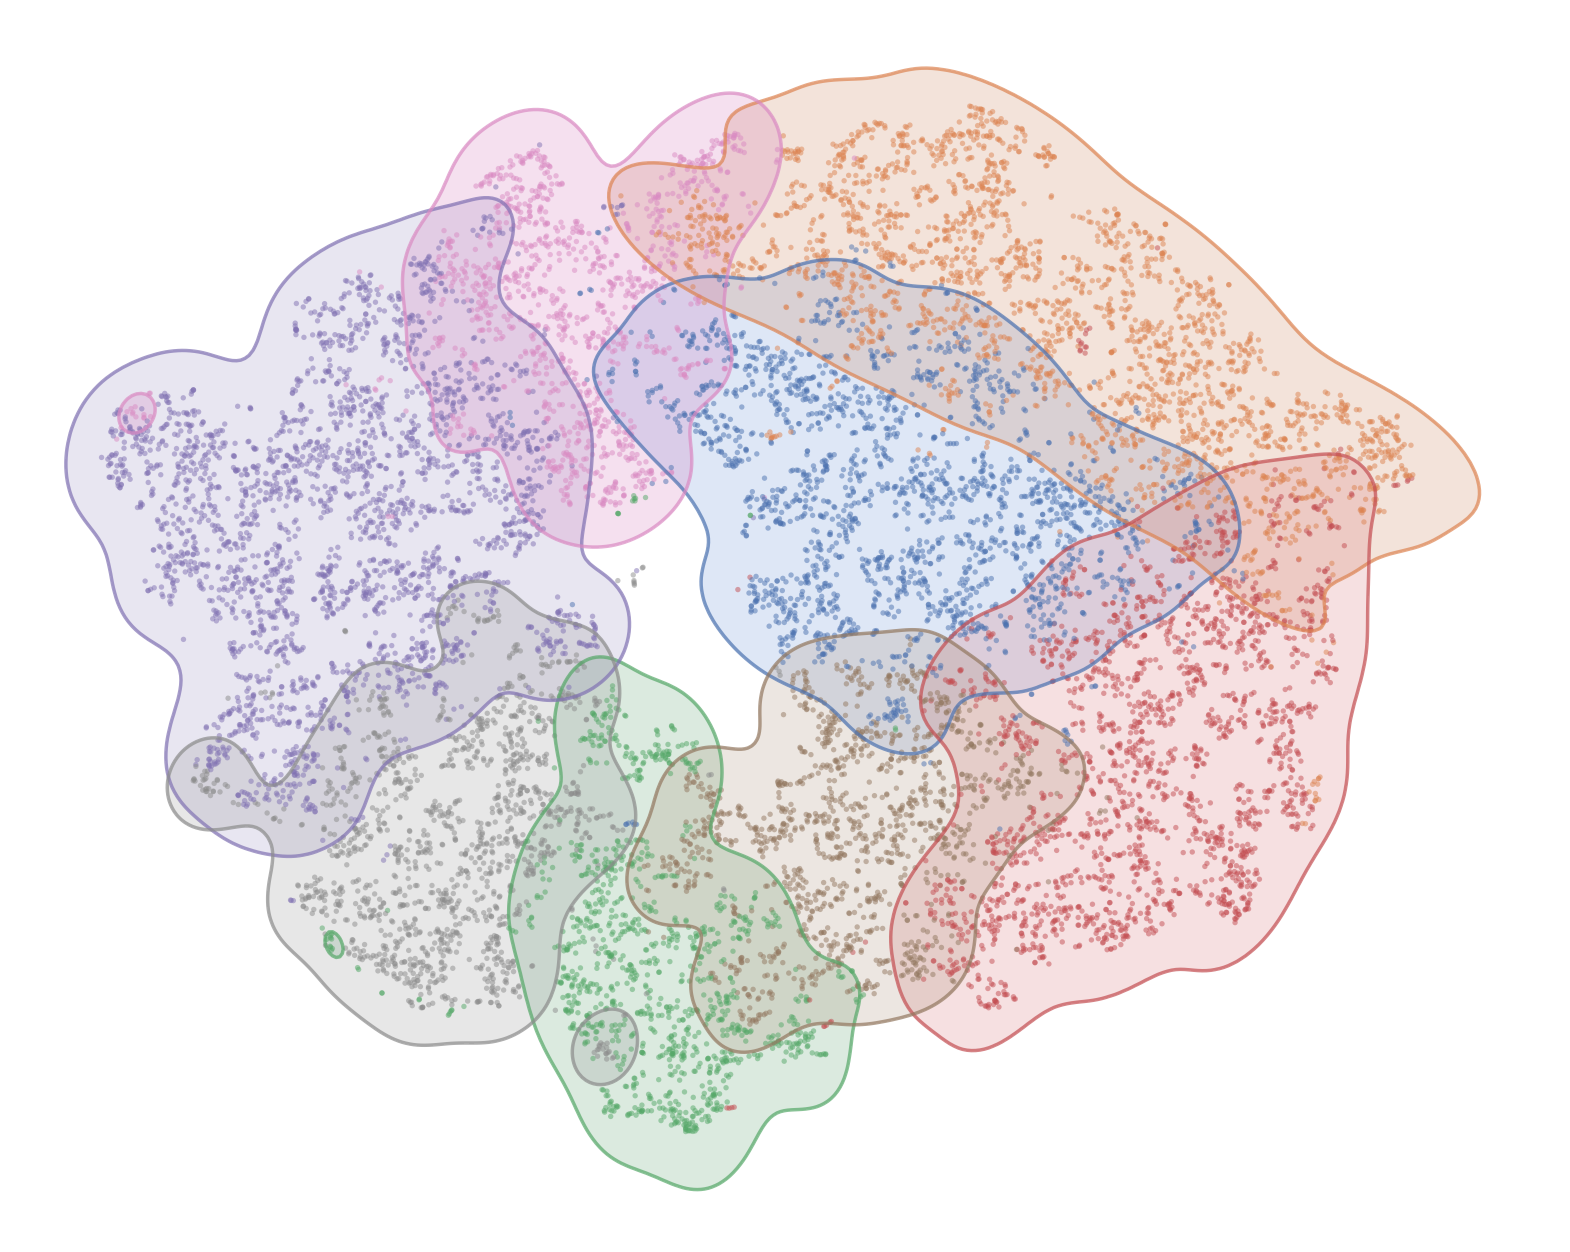

Saved Wind Speed plot to: C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\cluster_analysis_wind_speed_distribution.png


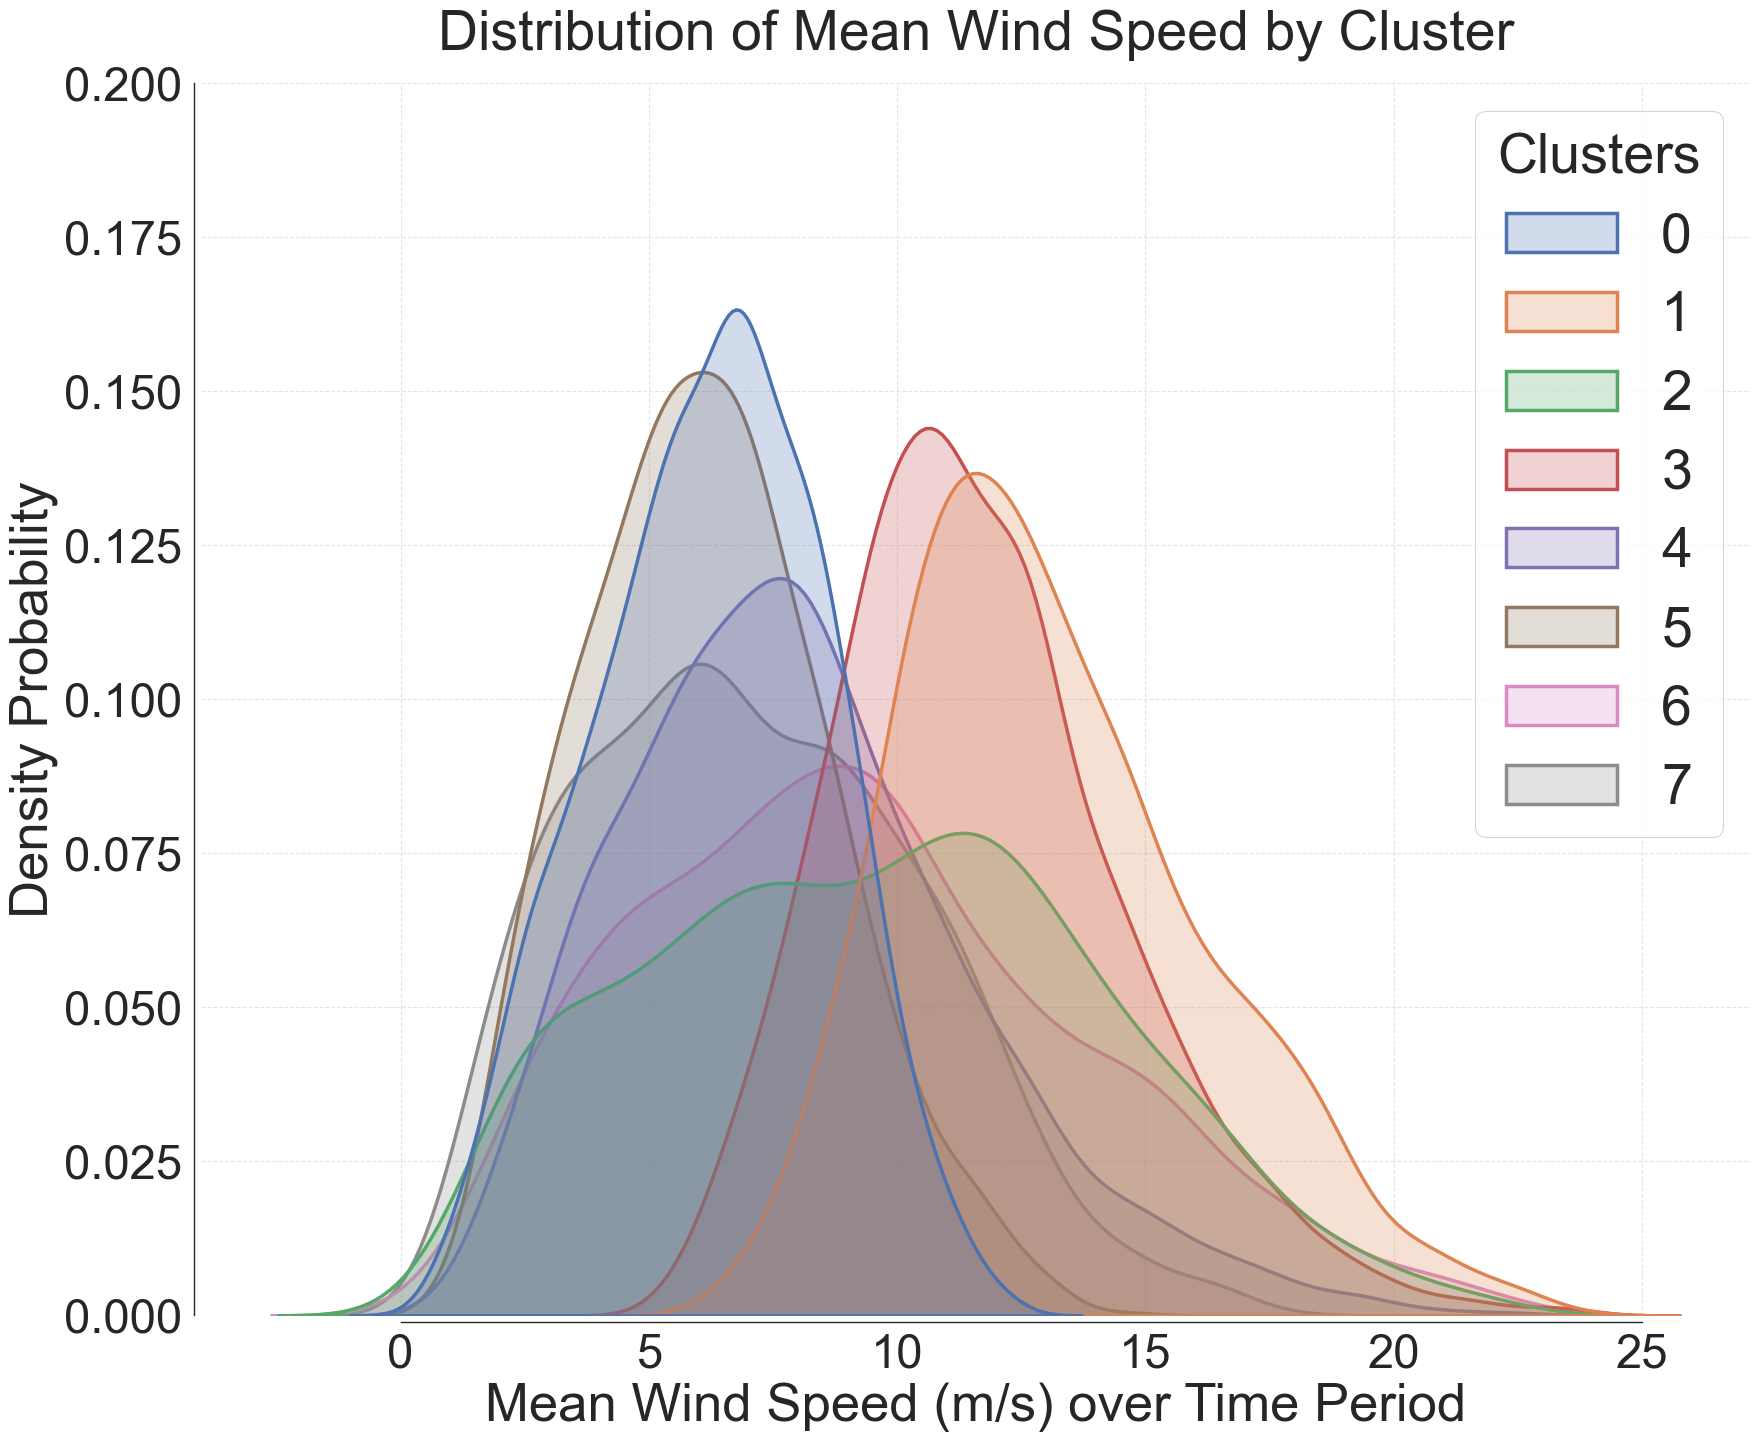

Saved Wind Rose plot to: C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\cluster_analysis_wind_roses.png


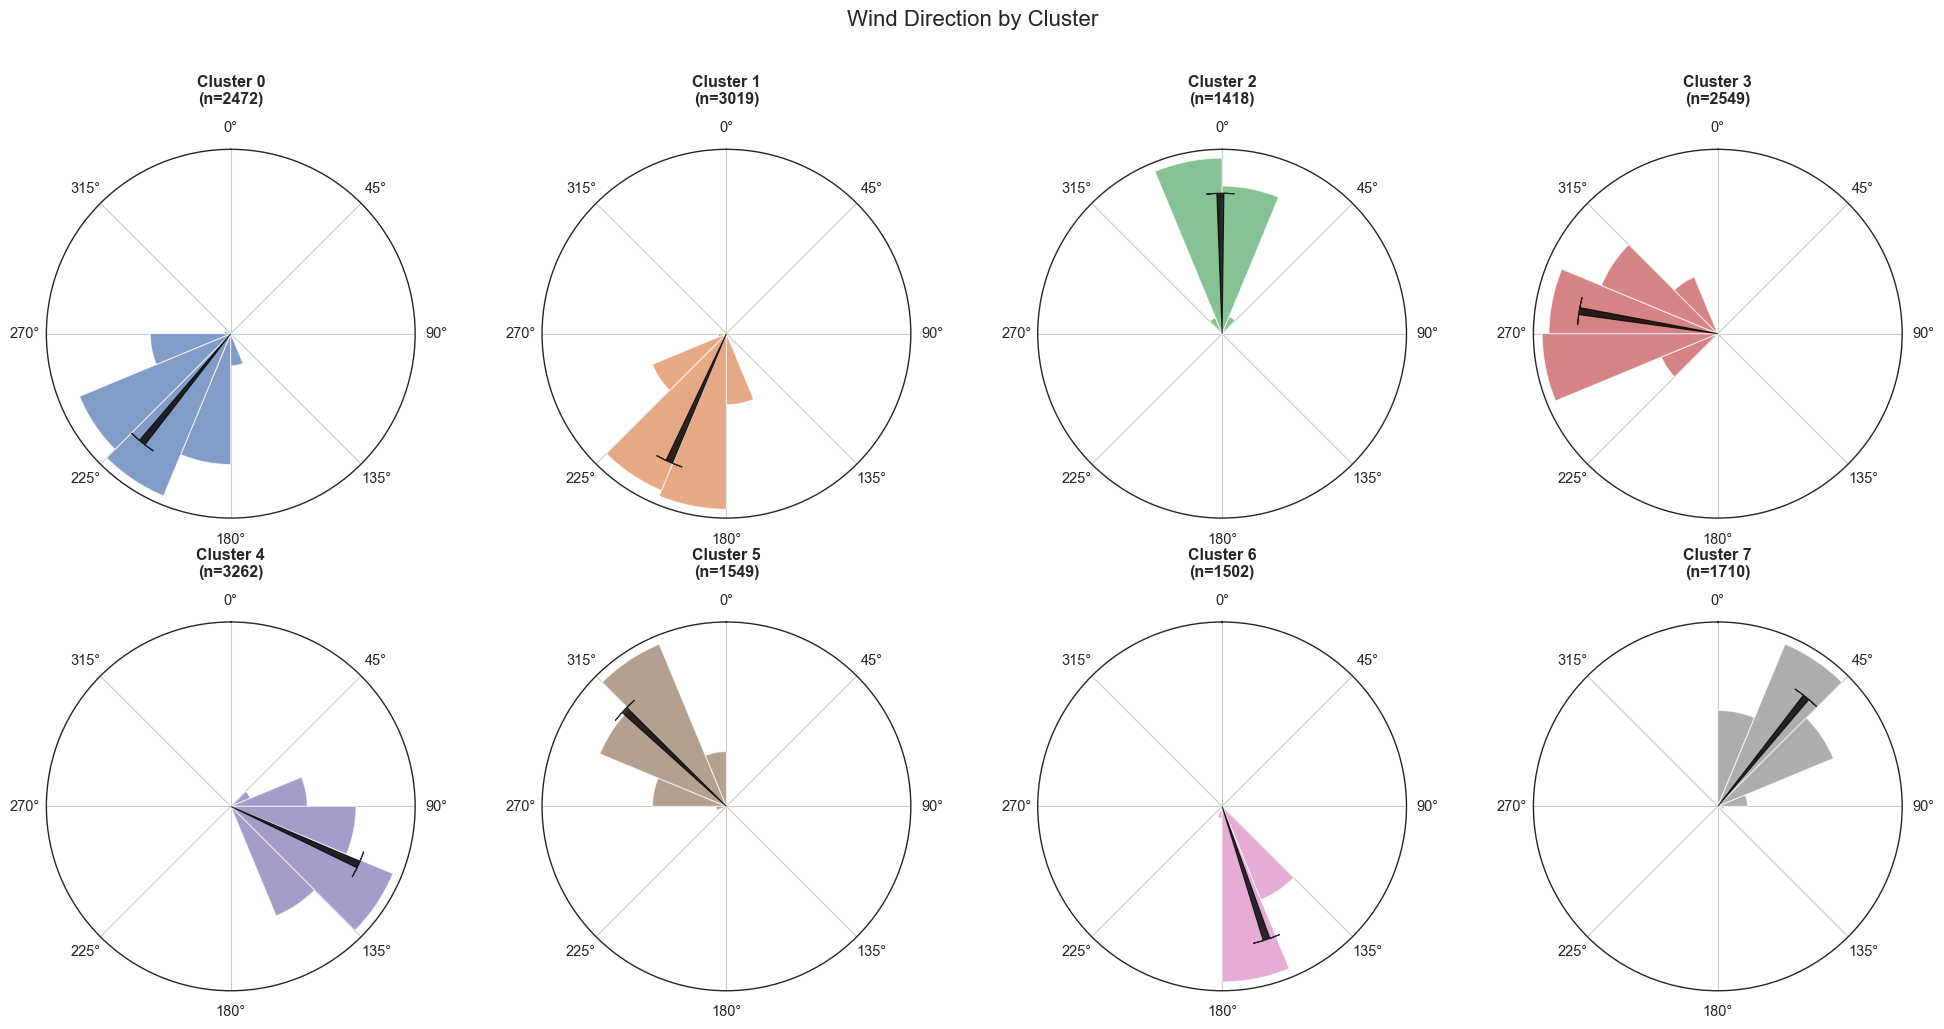


MODEL TRAINING

Cluster 0: 2013 periods, 10065 samples, 20 features
Cluster 1: 2436 periods, 12180 samples, 20 features
Cluster 2: 1104 periods, 5520 samples, 20 features
Cluster 3: 2057 periods, 10285 samples, 20 features
Cluster 4: 2646 periods, 13230 samples, 20 features
Cluster 5: 1250 periods, 6250 samples, 20 features
Cluster 6: 1120 periods, 5600 samples, 20 features
Cluster 7: 1358 periods, 6790 samples, 20 features
Cluster 0: 459 periods, 2295 samples, 20 features
Cluster 1: 583 periods, 2915 samples, 20 features
Cluster 2: 314 periods, 1570 samples, 20 features
Cluster 3: 492 periods, 2460 samples, 20 features
Cluster 4: 616 periods, 3080 samples, 20 features
Cluster 5: 299 periods, 1495 samples, 20 features
Cluster 6: 382 periods, 1910 samples, 20 features
Cluster 7: 352 periods, 1760 samples, 20 features

Training GP Models...
[1/8] Training Cluster 0... 

KeyboardInterrupt: 

In [ ]:
results = run_complete_pipeline(df, time_period_grid=[6], k_clusters_grid=[8], 
                                latent_dim=8, test_ratio=0.2, epochs=200, random_state=63, device='cpu', save_results=True, save_dir=r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures") 

Device: cpu

OPTIMAL CONFIGURATION SEARCH


Processing 6h periods...
Extracted: 17481 periods (skipped 27 discontinuous)
Full: (17481, 17, 6), VAE: (17481, 6, 6)
Timeseries randomly split into 13984 train periods and 3497 test periods
VAE loaded from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Models\VAEs\Final_VAE\vae_config_6h_2.0y.pth
  Testing k=8... Clustering 13984 training periods into 8 clusters
  Cluster 0: 2121 periods
  Cluster 1: 1843 periods
  Cluster 2: 1500 periods
  Cluster 3: 1644 periods
  Cluster 4: 2784 periods
  Cluster 5: 1003 periods
  Cluster 6: 2345 periods
  Cluster 7: 744 periods
Assigning test periods to clusters
  Test latent features Shape: (3497, 8)
  Cluster 0: 443 test periods
  Cluster 1: 423 test periods
  Cluster 2: 413 test periods
  Cluster 3: 408 test periods
  Cluster 4: 677 test periods
  Cluster 5: 279 test periods
  Cluster 6: 592 test periods
  Cluster 7: 262 test periods
Score: 0.561

BEST CONFIGURATION:
  Time Period: 6h
  Clust

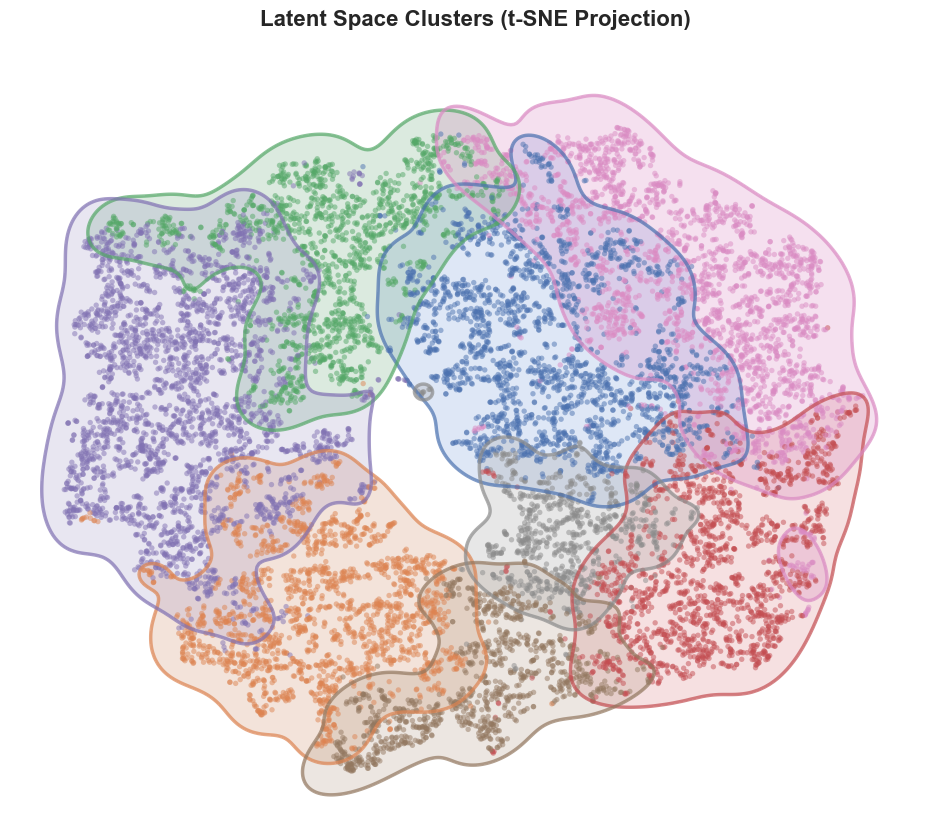

Saved Wind Speed plot to: C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\cluster_analysis_wind_speed_distribution.png


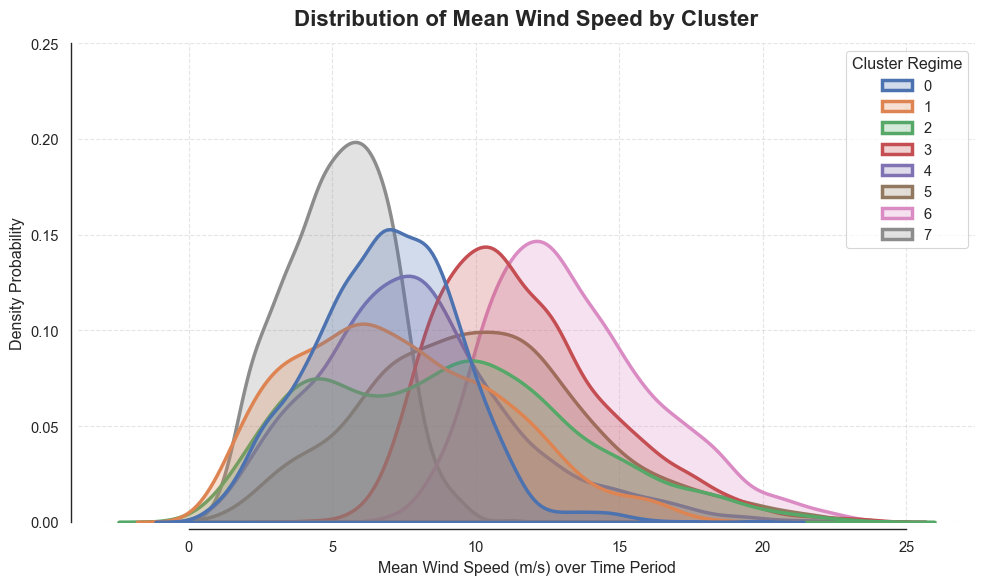

Saved Wind Rose plot to: C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\cluster_analysis_wind_roses.png


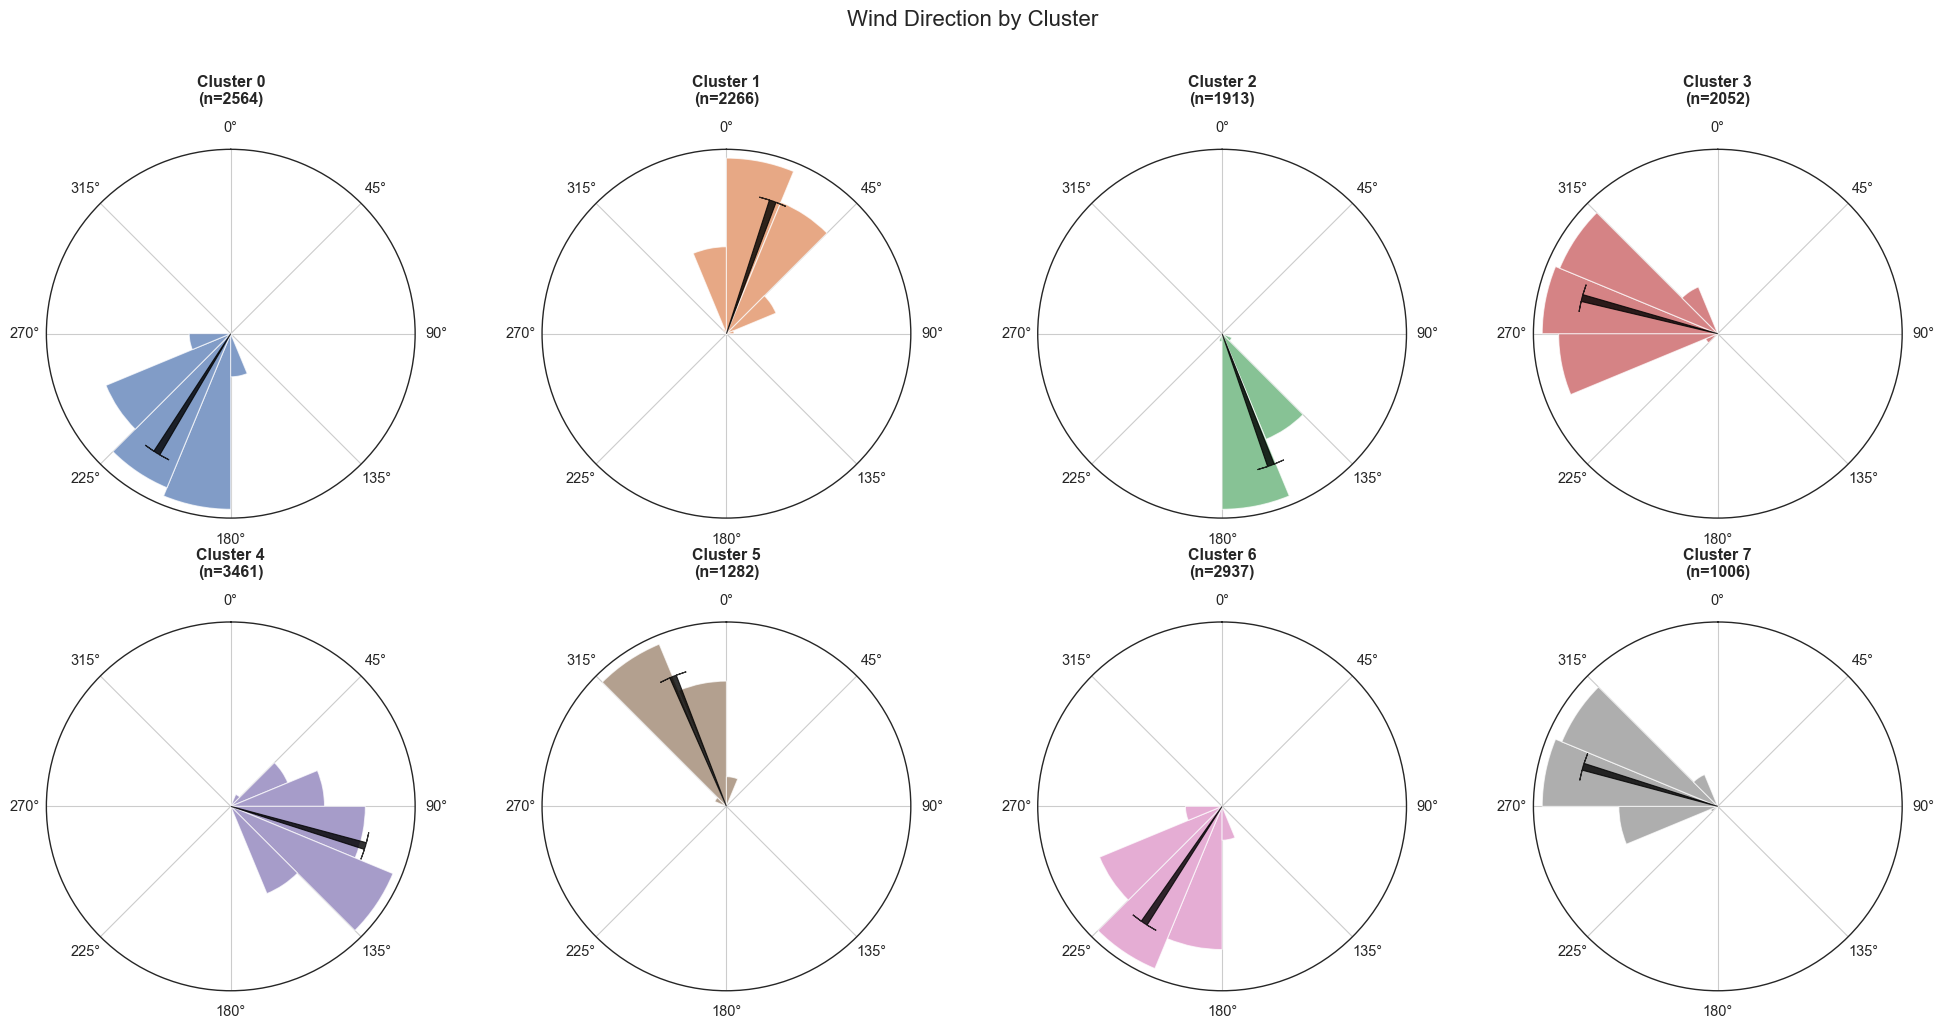


MODEL TRAINING

Cluster 0: 2121 periods, 10605 samples, 20 features
Cluster 1: 1843 periods, 9215 samples, 20 features
Cluster 2: 1500 periods, 7500 samples, 20 features
Cluster 3: 1644 periods, 8220 samples, 20 features
Cluster 4: 2784 periods, 13920 samples, 20 features
Cluster 5: 1003 periods, 5015 samples, 20 features
Cluster 6: 2345 periods, 11725 samples, 20 features
Cluster 7: 744 periods, 3720 samples, 20 features
Cluster 0: 443 periods, 2215 samples, 20 features
Cluster 1: 423 periods, 2115 samples, 20 features
Cluster 2: 413 periods, 2065 samples, 20 features
Cluster 3: 408 periods, 2040 samples, 20 features
Cluster 4: 677 periods, 3385 samples, 20 features
Cluster 5: 279 periods, 1395 samples, 20 features
Cluster 6: 592 periods, 2960 samples, 20 features
Cluster 7: 262 periods, 1310 samples, 20 features

Training GP Models...
[1/8] Training Cluster 0... ✓ MAE: 25.1 MW, R²: 0.950
[2/8] Training Cluster 1... ✓ MAE: 20.2 MW, R²: 0.979
[3/8] Training Cluster 2... ✓ MAE: 22.6 MW

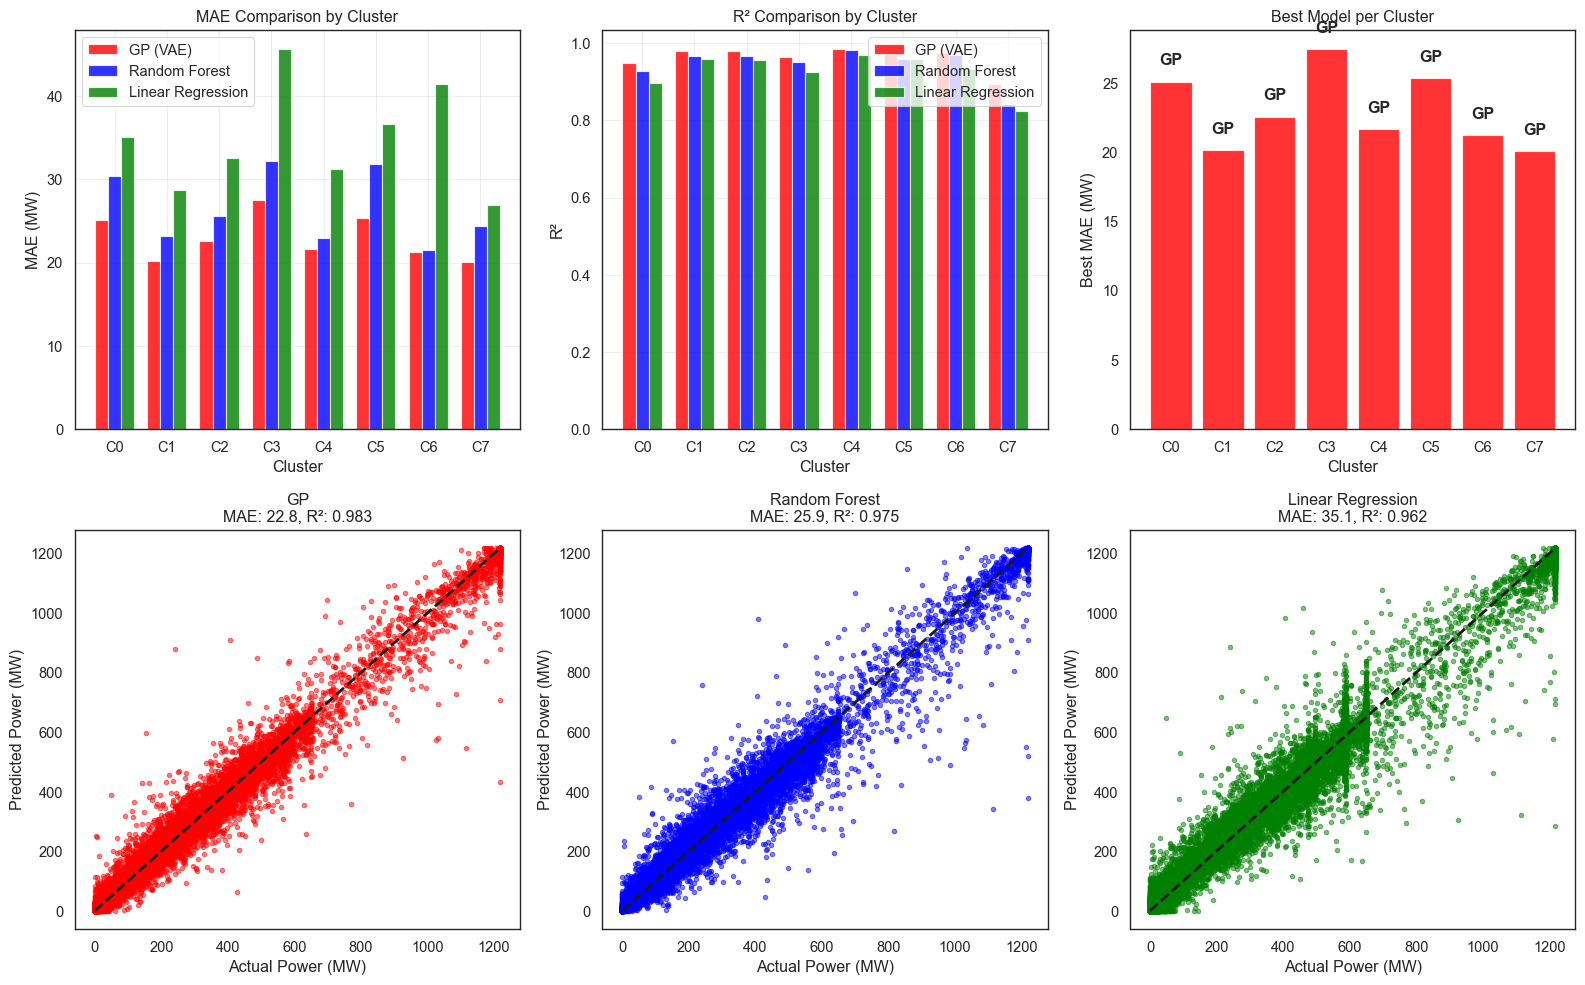


Creating prediction plots for 8 clusters...
Displaying first 72 hours of predictions


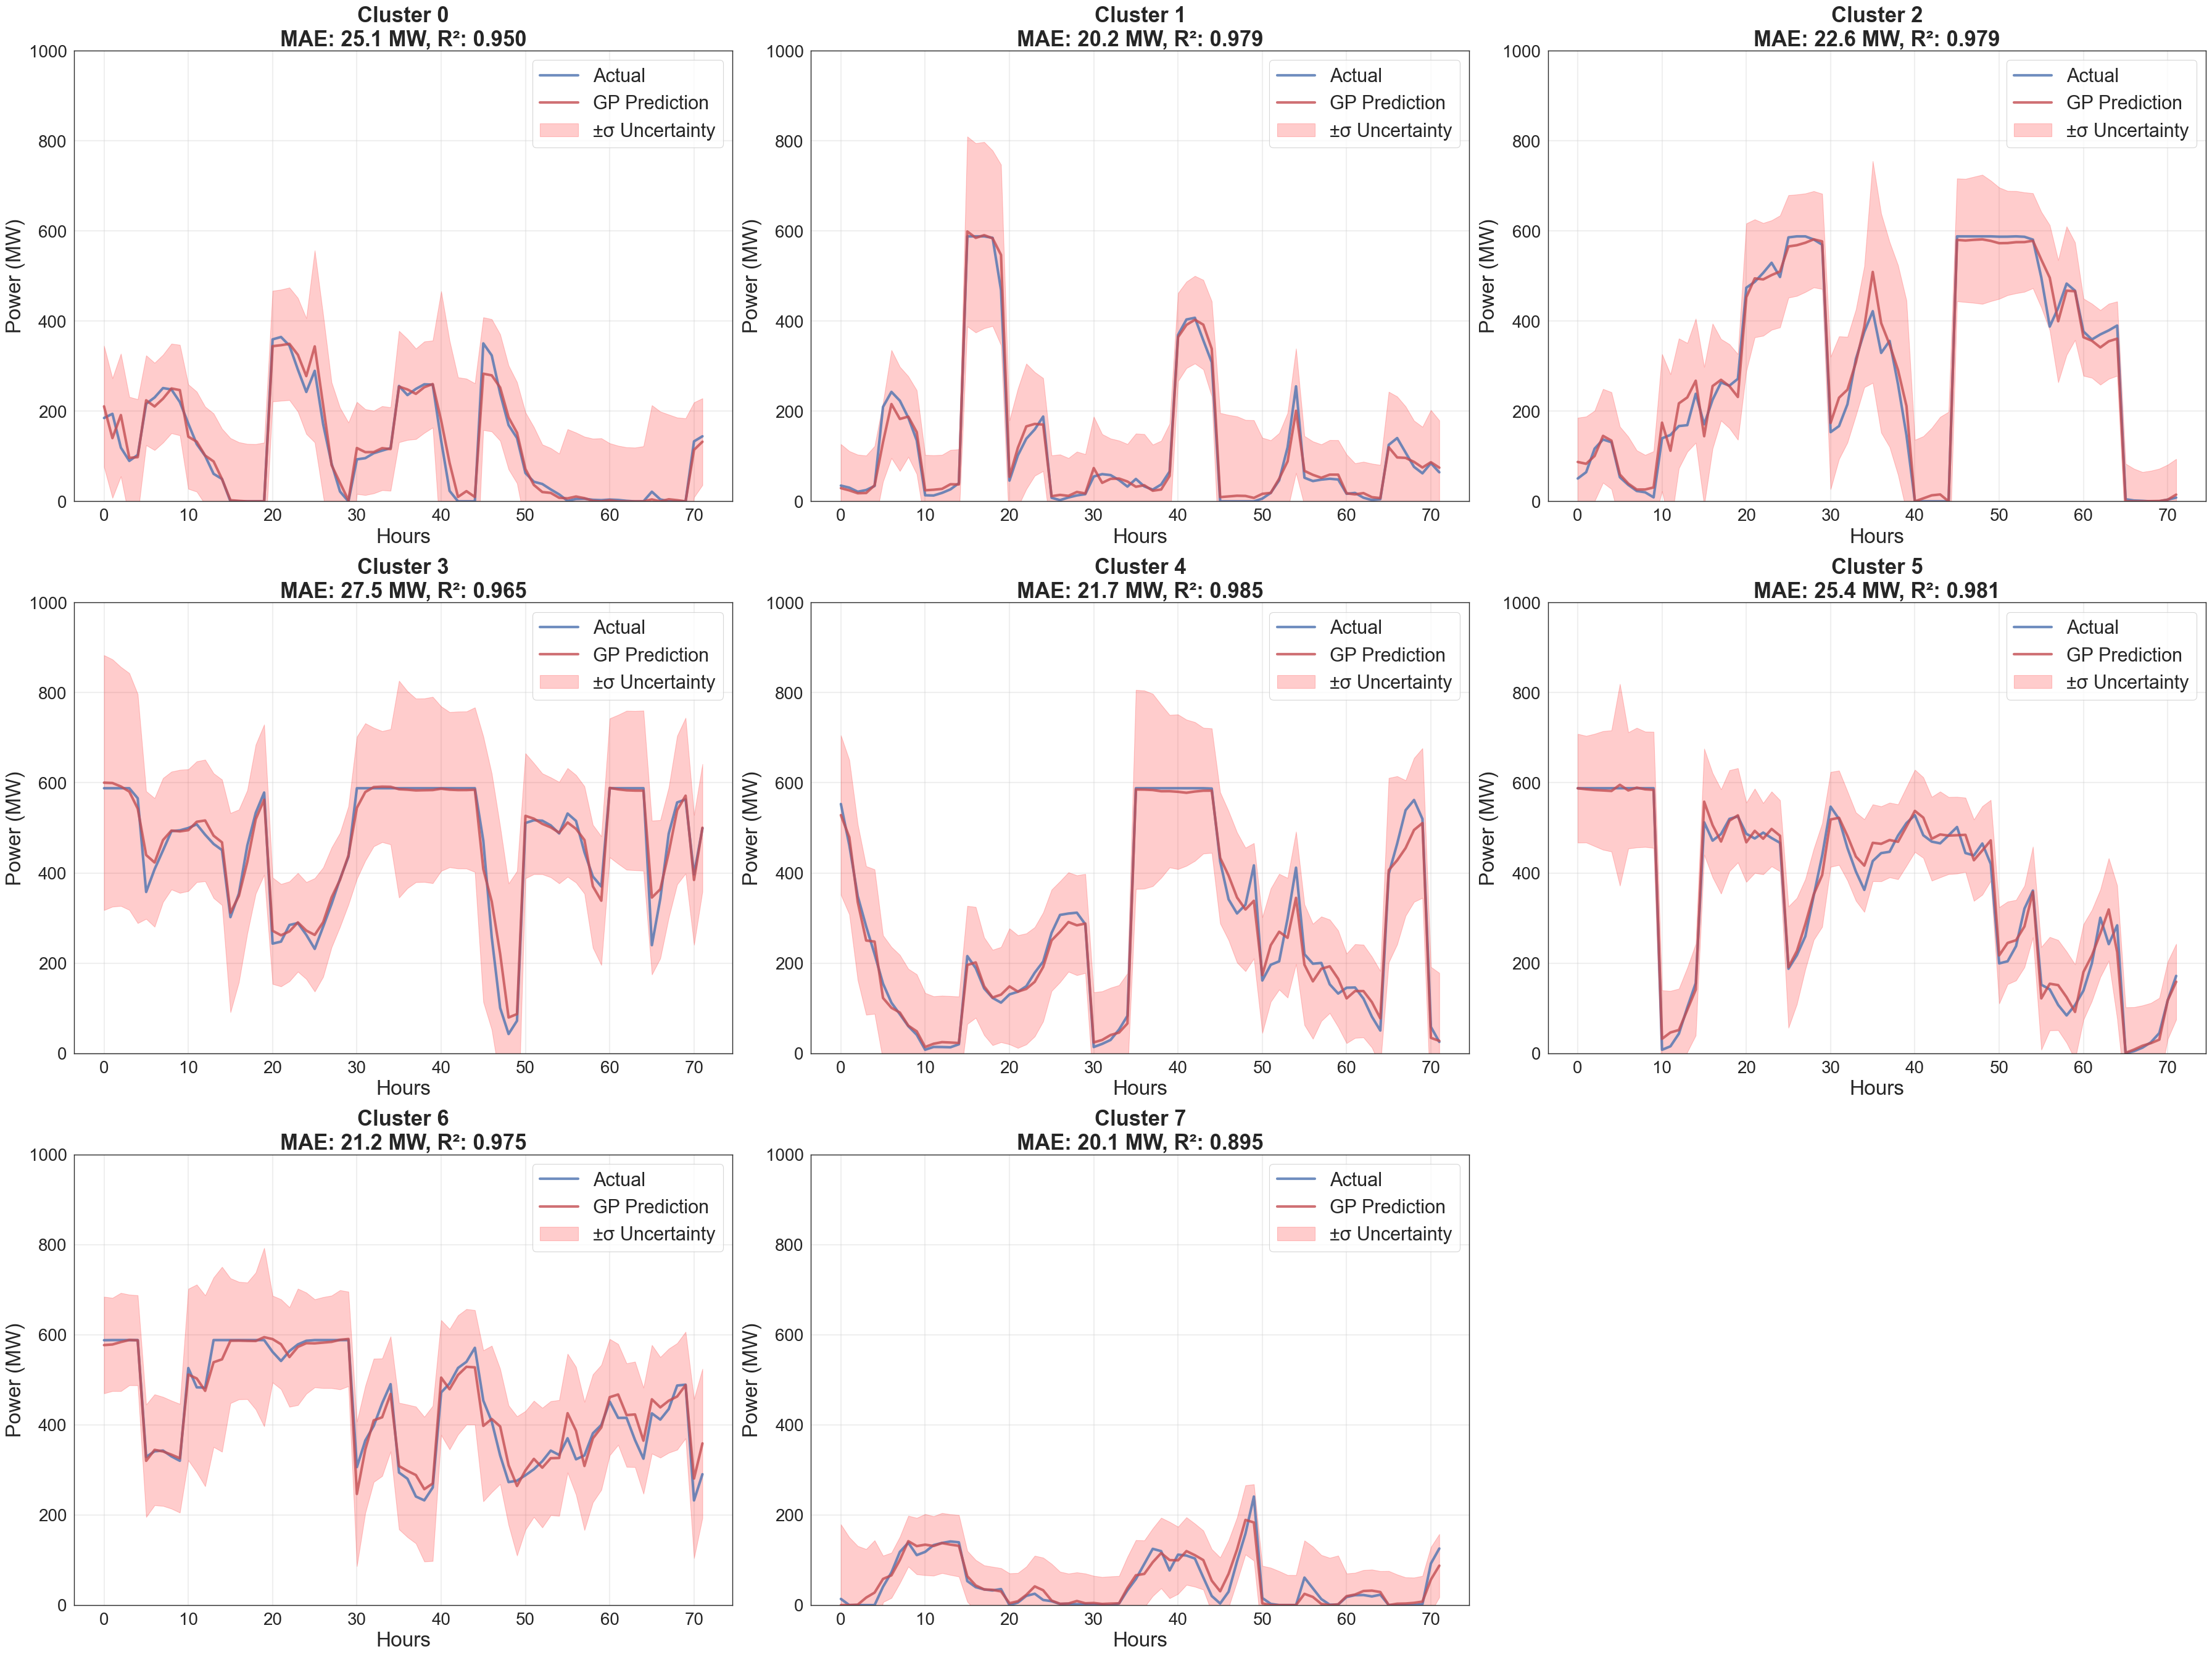


Prediction Plot Summary:
Cluster 0: MAE=25.1 MW, R²=0.950 (2215 test points)
Cluster 1: MAE=20.2 MW, R²=0.979 (2115 test points)
Cluster 2: MAE=22.6 MW, R²=0.979 (2065 test points)
Cluster 3: MAE=27.5 MW, R²=0.965 (2040 test points)
Cluster 4: MAE=21.7 MW, R²=0.985 (3385 test points)
Cluster 5: MAE=25.4 MW, R²=0.981 (1395 test points)
Cluster 6: MAE=21.2 MW, R²=0.975 (2960 test points)
Cluster 7: MAE=20.1 MW, R²=0.895 (1310 test points)
Spider diagram saved to C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\spider_mae_by_farm.png


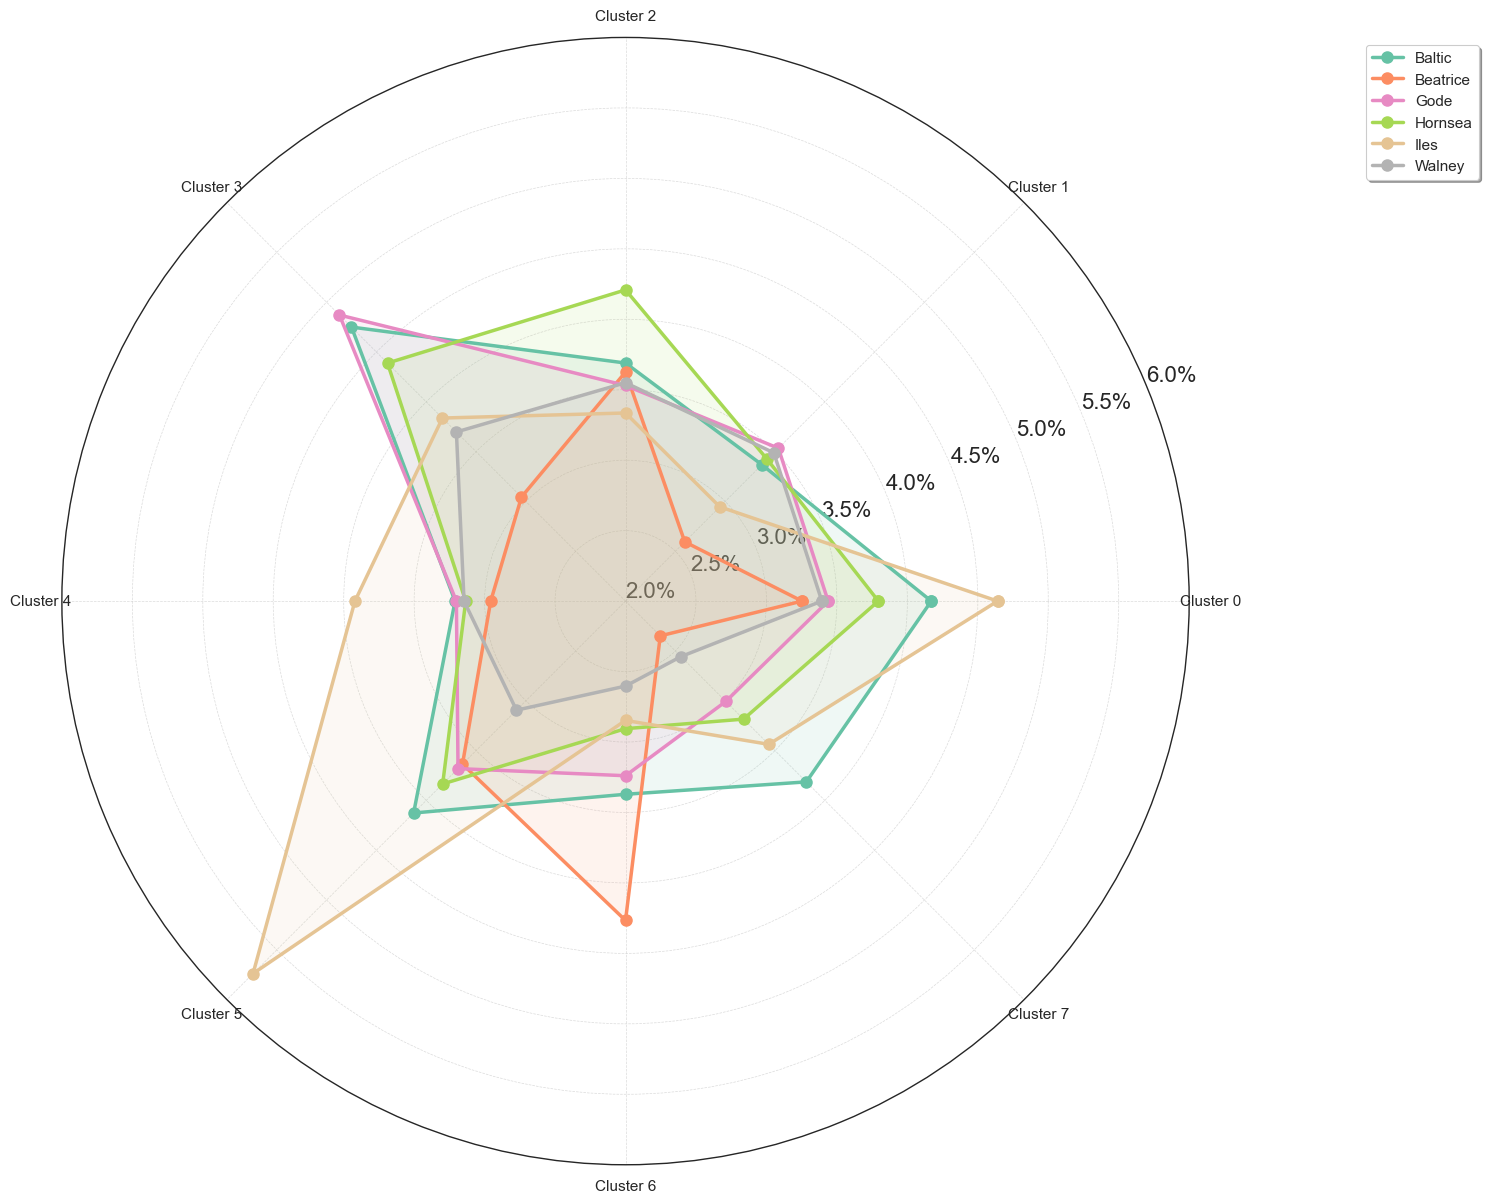

In [ ]:
results = run_complete_pipeline(df, time_period_grid=[6], k_clusters_grid=[8], 
                                latent_dim=8, test_ratio=0.2, epochs=200, random_state=42, device='cpu', save_results=True, save_dir=r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures") 

Device: cpu

OPTIMAL CONFIGURATION SEARCH


Processing 6h periods...
Extracted: 17481 periods (skipped 27 discontinuous)
Full: (17481, 17, 6), VAE: (17481, 6, 6)
Timeseries randomly split into 13984 train periods and 3497 test periods
VAE loaded from C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Models\VAEs\Final_VAE\vae_config_6h_2.0y.pth
  Testing k=8... Clustering 13984 training periods into 8 clusters
  Cluster 0: 2143 periods
  Cluster 1: 2547 periods
  Cluster 2: 1891 periods
  Cluster 3: 2142 periods
  Cluster 4: 1381 periods
  Cluster 5: 1108 periods
  Cluster 6: 1317 periods
  Cluster 7: 1455 periods
Assigning test periods to clusters
  Test latent features Shape: (3497, 8)
  Cluster 0: 441 test periods
  Cluster 1: 449 test periods
  Cluster 2: 490 test periods
  Cluster 3: 489 test periods
  Cluster 4: 412 test periods
  Cluster 5: 395 test periods
  Cluster 6: 391 test periods
  Cluster 7: 430 test periods
Score: 0.522

BEST CONFIGURATION:
  Time Period: 6h
  Clus

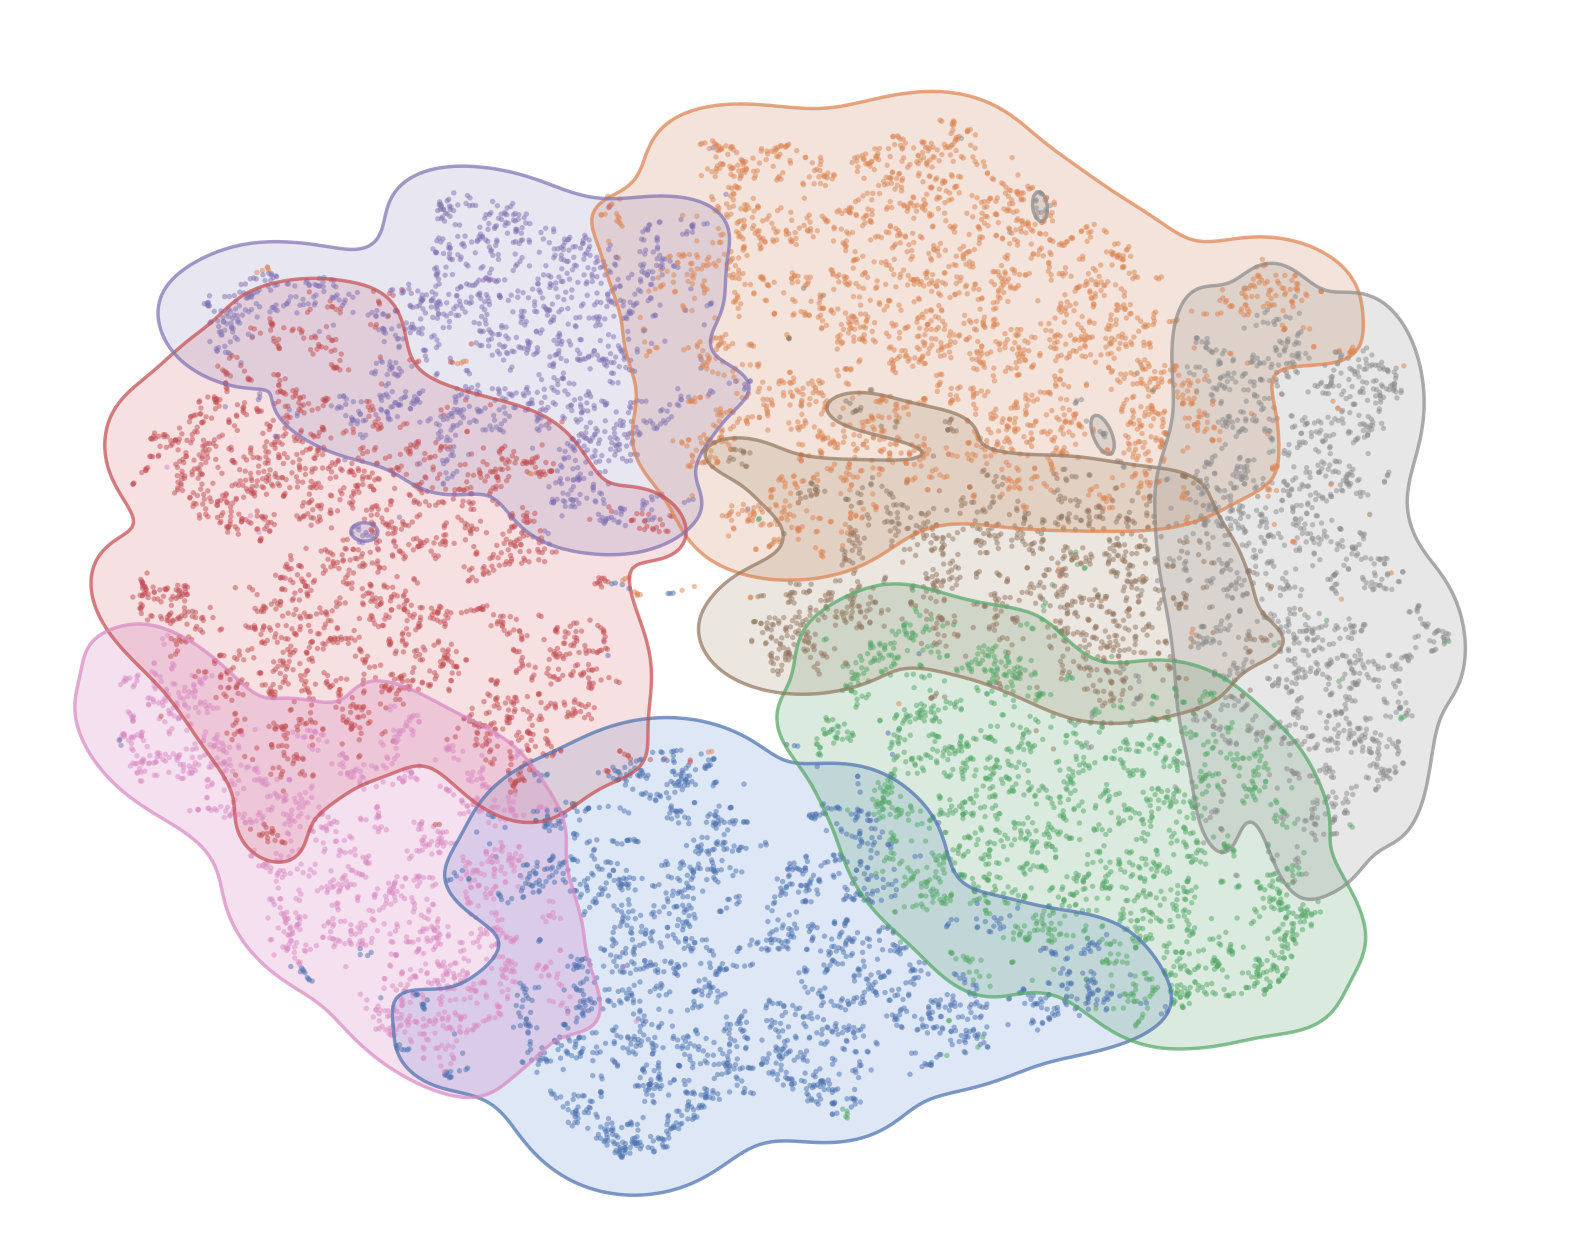

Saved Wind Speed plot to: C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\cluster_analysis_wind_speed_distribution.png


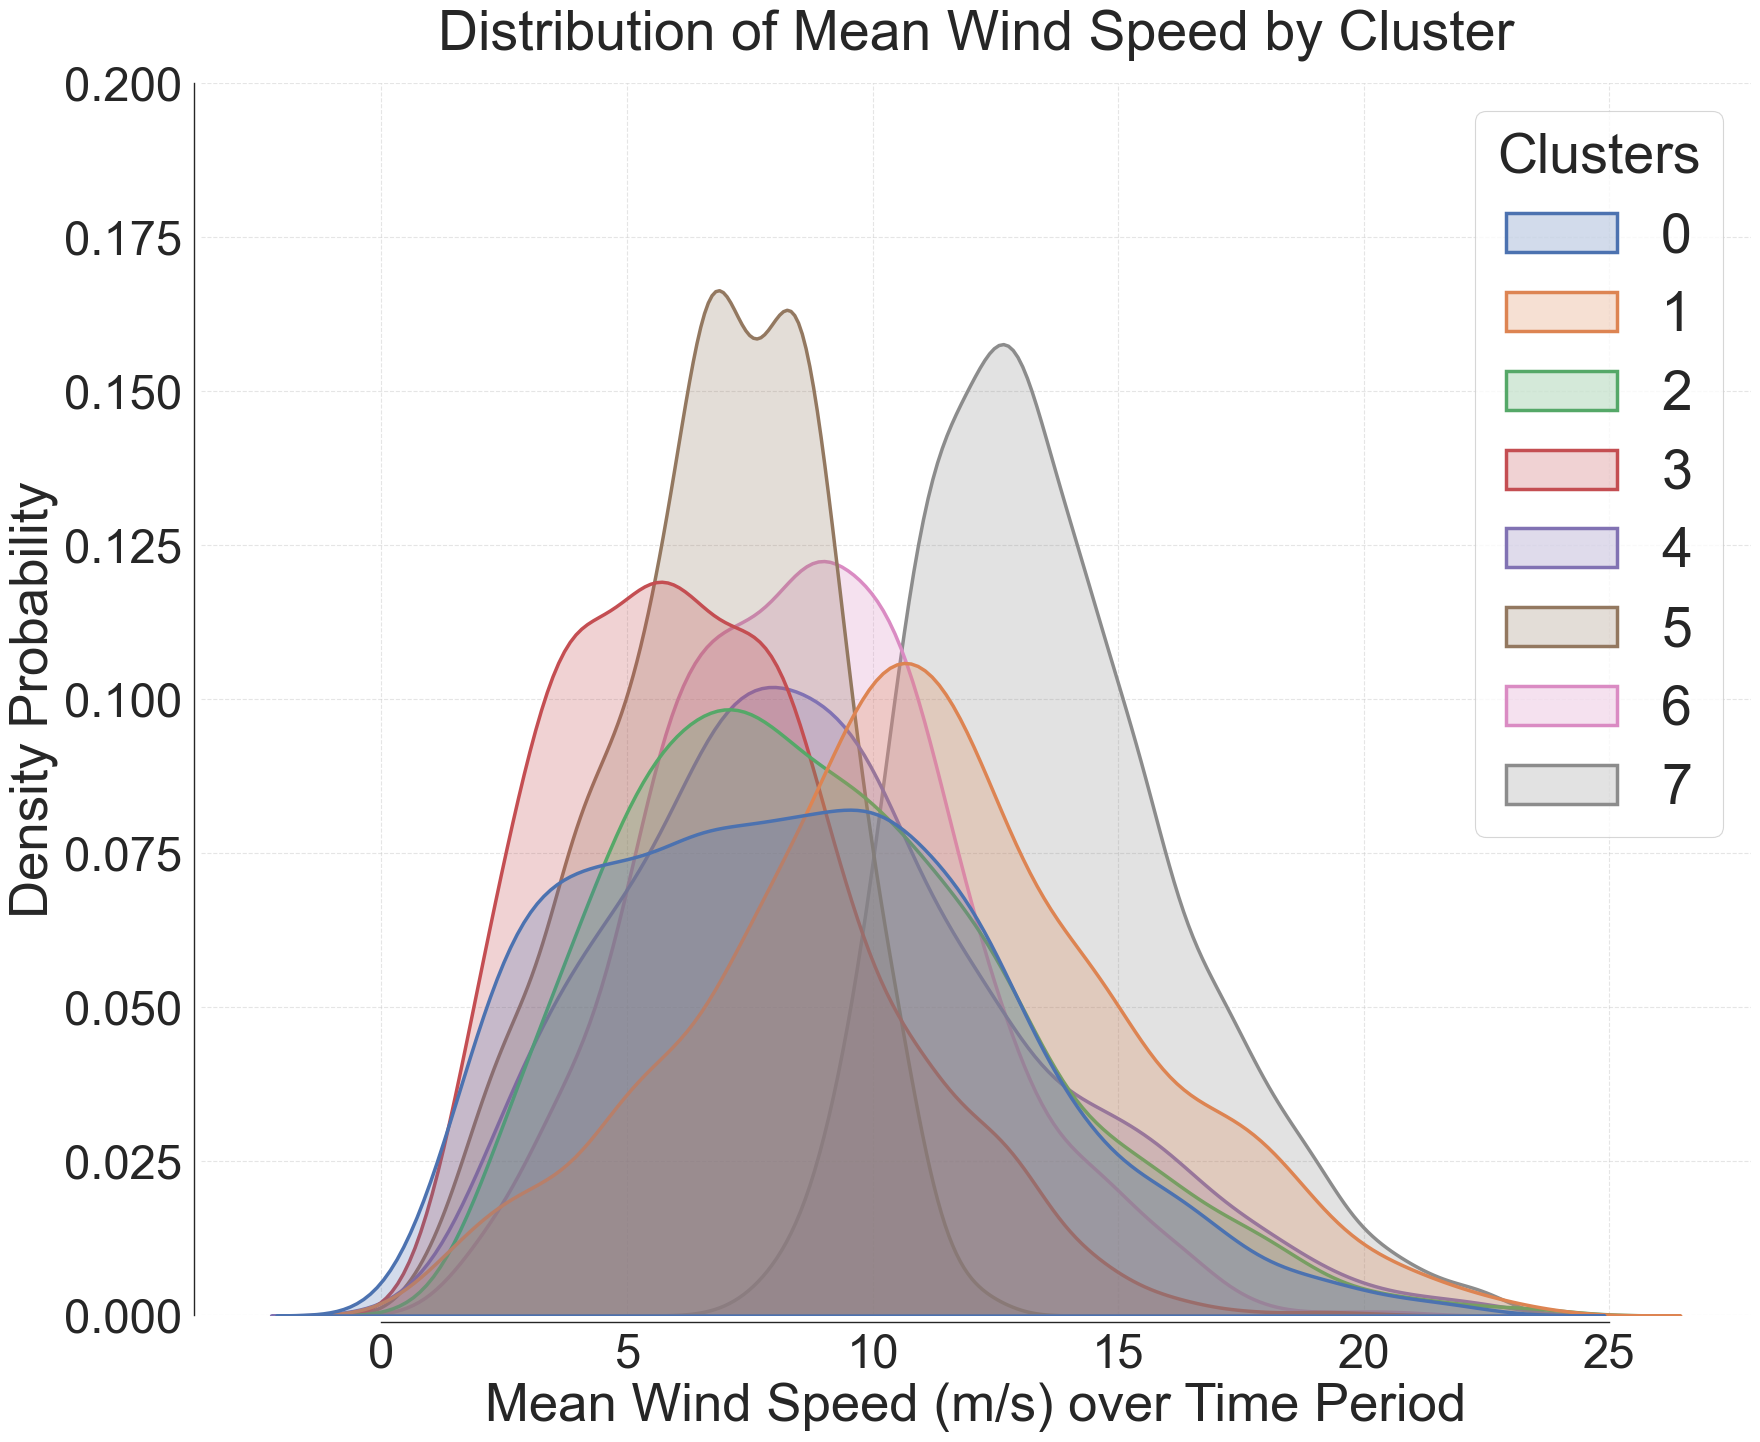

Saved Wind Rose plot to: C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\cluster_analysis_wind_roses.png


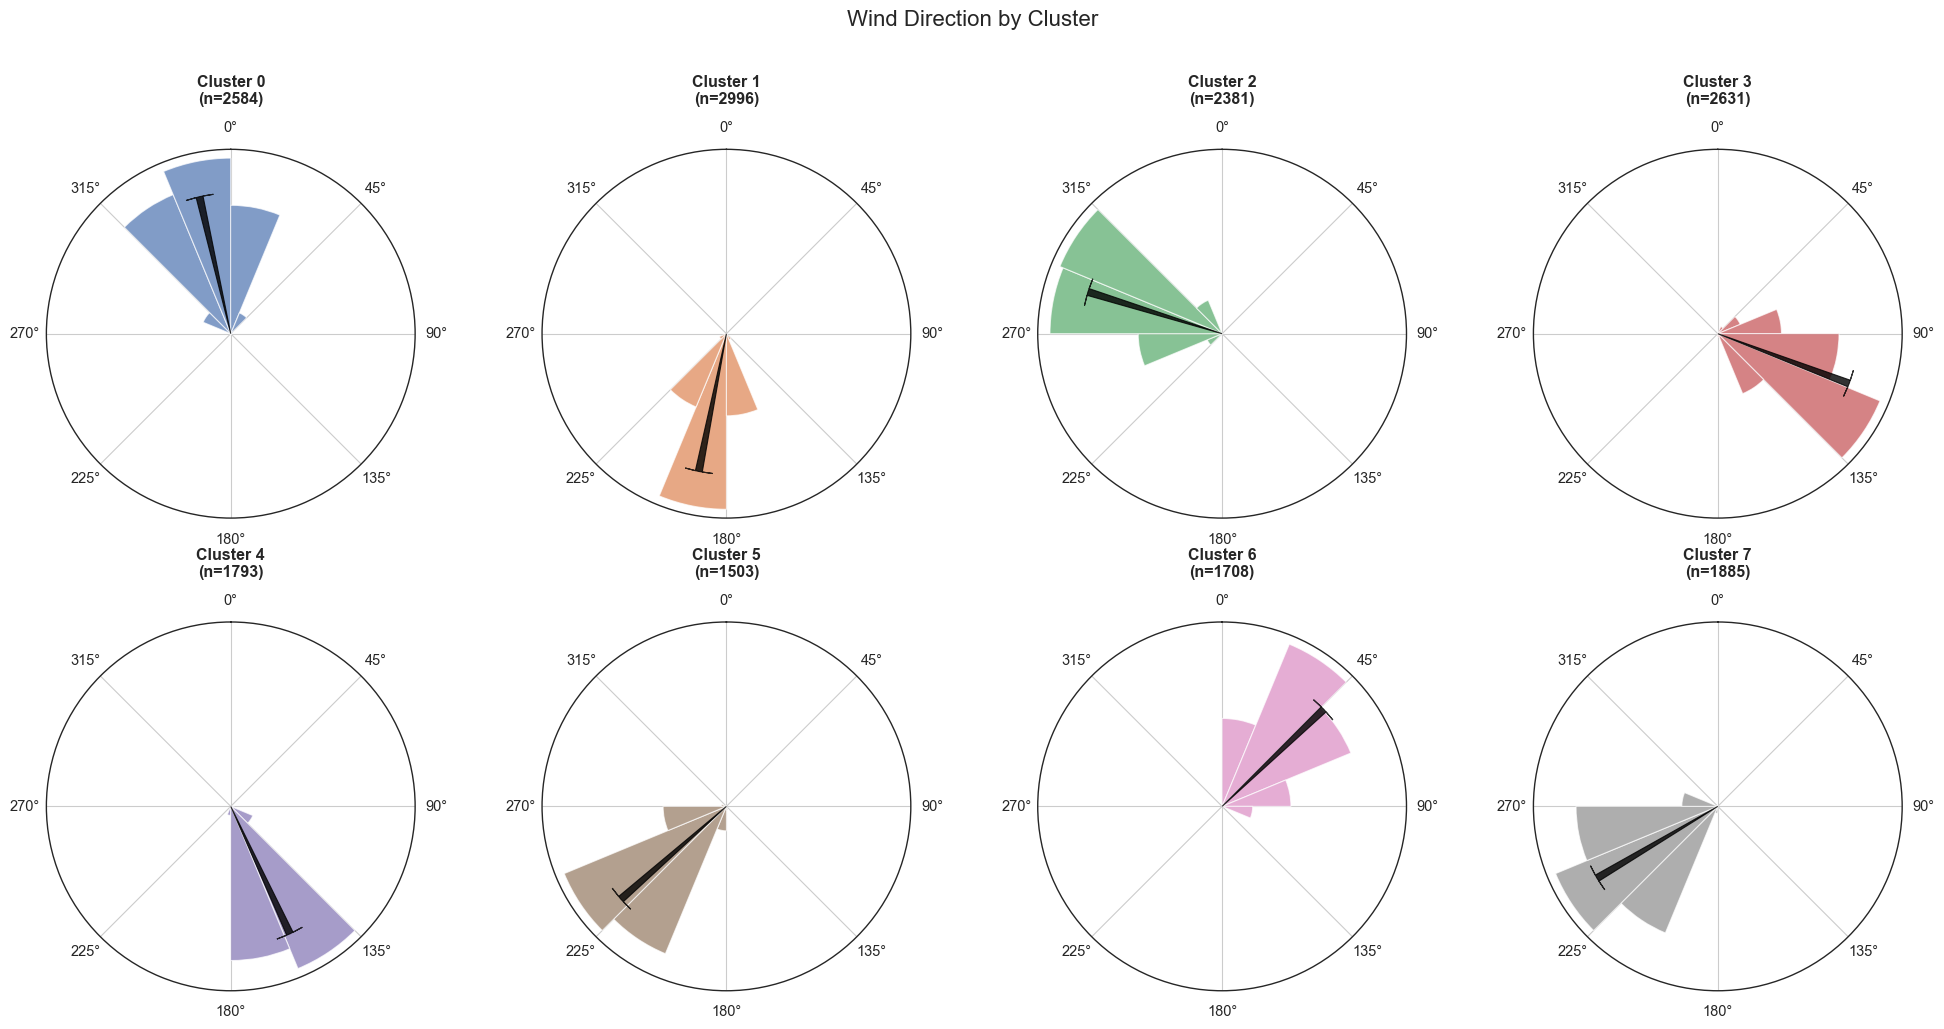


MODEL TRAINING

Cluster 0: 2143 periods, 10715 samples, 20 features
Cluster 1: 2547 periods, 12735 samples, 20 features
Cluster 2: 1891 periods, 9455 samples, 20 features
Cluster 3: 2142 periods, 10710 samples, 20 features
Cluster 4: 1381 periods, 6905 samples, 20 features
Cluster 5: 1108 periods, 5540 samples, 20 features
Cluster 6: 1317 periods, 6585 samples, 20 features
Cluster 7: 1455 periods, 7275 samples, 20 features
Cluster 0: 441 periods, 2205 samples, 20 features
Cluster 1: 449 periods, 2245 samples, 20 features
Cluster 2: 490 periods, 2450 samples, 20 features
Cluster 3: 489 periods, 2445 samples, 20 features
Cluster 4: 412 periods, 2060 samples, 20 features
Cluster 5: 395 periods, 1975 samples, 20 features
Cluster 6: 391 periods, 1955 samples, 20 features
Cluster 7: 430 periods, 2150 samples, 20 features

Training GP Models...
[1/8] Training Cluster 0...  MAE: 19.4 MW, R²: 0.989
[2/8] Training Cluster 1...  MAE: 24.1 MW, R²: 0.979
[3/8] Training Cluster 2...  MAE: 29.4 MW, 

In [ ]:
results = run_complete_pipeline(df, time_period_grid=[6], k_clusters_grid=[8], 
                                latent_dim=8, test_ratio=0.2, epochs=200, random_state=84, device='cpu', save_results=True, save_dir=r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures") 

In [32]:
def train_single_gp_baseline(train_cluster_datasets, test_cluster_datasets,
                            train_period_info, test_period_info, scalers=None,
                            device='cuda', training_iterations=100):
    
    print(f"\n{'='*120}")
    print("TRAINING SINGLE GP BASELINE (NO CLUSTERING)")
    print(f"{'='*120}\n")
    
    if device == 'cuda' and not torch.cuda.is_available():
        print("CUDA not available, using CPU")
        device = 'cpu'
    
    farm_capacities = {
        'Beatrice': 588, 'Hornsea': 1218, 'Walney': 649,
        'Baltic': 475, 'Gode': 582, 'Iles': 496
    }
    
    # Combine all training data BY CLUSTER (to enable stratification)
    cluster_train_data = {}  # {cluster_id: {'X': ..., 'y': ..., 'period_mapping': ...}}
    
    for cluster_id in sorted(train_cluster_datasets.keys()):
        cluster_train_data[cluster_id] = {
            'X': train_cluster_datasets[cluster_id]['X'],
            'y': train_cluster_datasets[cluster_id]['y'],
            'period_mapping': train_cluster_datasets[cluster_id]['period_idx_mapping'],
            'n_samples': len(train_cluster_datasets[cluster_id]['X'])
        }
    
    # Calculate total samples and cluster proportions
    total_train_samples = sum(data['n_samples'] for data in cluster_train_data.values())
    cluster_proportions = {
        cluster_id: data['n_samples'] / total_train_samples 
        for cluster_id, data in cluster_train_data.items()
    }
    
    print(f"Training data distribution across clusters:")
    print(f"{'Cluster':<10} {'Samples':<15} {'Proportion':<15}")
    print("-" * 60)
    for cluster_id in sorted(cluster_train_data.keys()):
        n = cluster_train_data[cluster_id]['n_samples']
        prop = cluster_proportions[cluster_id]
        print(f"{cluster_id:<10} {n:<15} {prop:<15.2%}")
    print(f"{'TOTAL':<10} {total_train_samples:<15}")
    print("-" * 60)
    
    # STRATIFIED SUBSAMPLING if needed
    max_samples = 18000
    
    if total_train_samples > max_samples:
        print(f"\n⚠ Total samples ({total_train_samples}) exceeds limit ({max_samples})")
        print(f"Applying STRATIFIED subsampling to preserve cluster proportions...\n")
        
        np.random.seed(42)
        
        sampled_X_parts = []
        sampled_y_parts = []
        sampled_period_parts = []
        
        print(f"{'Cluster':<10} {'Original':<15} {'Target':<15} {'Sampled':<15} {'Proportion':<15}")
        print("-" * 80)
        
        for cluster_id in sorted(cluster_train_data.keys()):
            data = cluster_train_data[cluster_id]
            original_n = data['n_samples']
            
            # Calculate target number of samples for this cluster
            target_n = int(max_samples * cluster_proportions[cluster_id])
            
            # Ensure we sample at least 1 sample from each cluster
            target_n = max(1, target_n)
            
            # Can't sample more than we have
            actual_n = min(target_n, original_n)
            
            # Randomly sample from this cluster
            if actual_n < original_n:
                sample_indices = np.random.choice(original_n, actual_n, replace=False)
            else:
                sample_indices = np.arange(original_n)
            
            sampled_X_parts.append(data['X'][sample_indices])
            sampled_y_parts.append(data['y'][sample_indices])
            sampled_period_parts.extend([data['period_mapping'][i] for i in sample_indices])
            
            actual_prop = actual_n / max_samples if max_samples > 0 else 0
            
            print(f"{cluster_id:<10} {original_n:<15} {target_n:<15} {actual_n:<15} {actual_prop:<15.2%}")
        
        X_train = np.vstack(sampled_X_parts)
        y_train = np.hstack(sampled_y_parts)
        all_train_period_mapping = sampled_period_parts
        
        print("-" * 80)
        print(f"{'TOTAL':<10} {total_train_samples:<15} {max_samples:<15} {len(X_train):<15}")
        print(f"\n✓ Stratified subsampling complete. Cluster proportions preserved.\n")
        
    else:
        # No subsampling needed - use all data
        print(f"No subsampling needed ({total_train_samples} ≤ {max_samples})\n")
        
        all_X_train = []
        all_y_train = []
        all_train_period_mapping = []
        
        for cluster_id in sorted(cluster_train_data.keys()):
            all_X_train.append(cluster_train_data[cluster_id]['X'])
            all_y_train.append(cluster_train_data[cluster_id]['y'])
            all_train_period_mapping.extend(cluster_train_data[cluster_id]['period_mapping'])
        
        X_train = np.vstack(all_X_train)
        y_train = np.hstack(all_y_train)
    
    # Combine all test data (no subsampling for test)
    all_X_test = []
    all_y_test = []
    all_test_period_mapping = []
    
    for cluster_id in sorted(test_cluster_datasets.keys()):
        all_X_test.append(test_cluster_datasets[cluster_id]['X'])
        all_y_test.append(test_cluster_datasets[cluster_id]['y'])
        all_test_period_mapping.extend(test_cluster_datasets[cluster_id]['period_idx_mapping'])
    
    X_test = np.vstack(all_X_test)
    y_test = np.hstack(all_y_test)
    
    print(f"Final dataset sizes:")
    print(f"  Training: {len(X_train)} samples")
    print(f"  Test: {len(X_test)} samples\n")
    
    # Map test samples to farms
    test_sample_farm_ids = np.array([test_period_info[idx]['farm_id'] 
                                     for idx in all_test_period_mapping])
    
    power_scaler = scalers.get('Power') if scalers else None
    
    try:
        print("Training single global GP model...")
        model, likelihood = train_gpytorch_model(X_train, y_train, training_iterations, device)
        
        print("Generating predictions...")
        y_pred_scaled, y_std_scaled = predict_gpytorch_model(model, likelihood, X_test, device)
        
        if power_scaler is not None:
            y_pred_original = power_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
            y_test_original = power_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
            y_std_original = y_std_scaled * (power_scaler.data_max_[0] - power_scaler.data_min_[0])
            y_pred_original = np.clip(y_pred_original, 0, max(farm_capacities.values()))
            
            mae = mean_absolute_error(y_test_original, y_pred_original)
            r2 = r2_score(y_test_original, y_pred_original)
            rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
            
            # Per-farm metrics
            farm_metrics = {}
            for farm_id in np.unique(test_sample_farm_ids):
                farm_mask = test_sample_farm_ids == farm_id
                n_farm_samples = np.sum(farm_mask)
                if n_farm_samples == 0:
                    continue
                
                farm_capacity = farm_capacities.get(farm_id, None)
                if farm_capacity:
                    farm_y_test = y_test_original[farm_mask]
                    farm_y_pred = y_pred_original[farm_mask]
                    farm_mae = mean_absolute_error(farm_y_test, farm_y_pred)
                    farm_metrics[farm_id] = {
                        'mae': farm_mae,
                        'mae_pct': (farm_mae / farm_capacity) * 100,
                        'rmse': np.sqrt(mean_squared_error(farm_y_test, farm_y_pred)),
                        'r2': r2_score(farm_y_test, farm_y_pred) if n_farm_samples >= 2 else np.nan,
                        'n_samples': int(n_farm_samples),
                        'capacity': farm_capacity
                    }
            
            print(f"\n{'='*80}")
            print(f"Single GP Results:")
            print(f"  MAE: {mae:.1f} MW")
            print(f"  RMSE: {rmse:.1f} MW")
            print(f"  R²: {r2:.3f}")
            print(f"  Training samples: {len(X_train)}")
            print(f"  Test samples: {len(X_test)}")
            print(f"{'='*80}\n")
            
            metrics = {
                'mae': mae,
                'r2': r2,
                'rmse': rmse,
                'farm_metrics': farm_metrics,
                'predictions_original': y_pred_original,
                'actual_original': y_test_original,
                'uncertainties_original': y_std_original,
                'n_train': len(X_train),
                'n_test': len(X_test)
            }
        else:
            mae_norm = mean_absolute_error(y_test, y_pred_scaled)
            r2_norm = r2_score(y_test, y_pred_scaled)
            print(f"MAE (normalized): {mae_norm:.4f}, R² (normalized): {r2_norm:.3f}")
            
            metrics = {
                'mae_norm': mae_norm,
                'r2_norm': r2_norm,
                'n_train': len(X_train),
                'n_test': len(X_test)
            }
        
        if device == 'cuda':
            torch.cuda.empty_cache()
        
        return {
            'gp_model': model,
            'likelihood': likelihood,
            'power_scaler': power_scaler,
            'metrics': metrics,
            'device': device,
            'cluster_proportions': cluster_proportions  # Store for reference
        }
    
    except Exception as e:
        print(f"Error training single GP baseline: {str(e)}")
        if device == 'cuda':
            torch.cuda.empty_cache()
        return None


def compare_cluster_vs_baseline(cluster_gp_models, single_gp_baseline):
    
    print(f"\n{'='*120}")
    print("ABLATION STUDY: CLUSTER-BASED vs SINGLE GP")
    print(f"{'='*120}\n")
    
    cluster_total_error = 0
    cluster_total_squared_error = 0
    cluster_total_samples = 0
    cluster_all_actual = []
    cluster_all_predicted = []
    
    for cluster_id in cluster_gp_models.keys():
        metrics = cluster_gp_models[cluster_id]['metrics']
        n = metrics['n_test']
        cluster_total_error += metrics['mae'] * n
        cluster_total_squared_error += (metrics['rmse'] ** 2) * n
        cluster_total_samples += n
        if 'actual_original' in metrics:
            cluster_all_actual.extend(metrics['actual_original'])
            cluster_all_predicted.extend(metrics['predictions_original'])
    
    cluster_weighted_mae = cluster_total_error / cluster_total_samples
    cluster_weighted_rmse = np.sqrt(cluster_total_squared_error / cluster_total_samples)
    cluster_r2 = r2_score(cluster_all_actual, cluster_all_predicted) if cluster_all_actual else np.nan
    
    single_metrics = single_gp_baseline['metrics']
    single_mae = single_metrics['mae']
    single_rmse = single_metrics['rmse']
    single_r2 = single_metrics['r2']
    single_samples = single_metrics['n_test']
    
    mae_improvement = ((single_mae - cluster_weighted_mae) / single_mae) * 100
    rmse_improvement = ((single_rmse - cluster_weighted_rmse) / single_rmse) * 100
    r2_improvement = cluster_r2 - single_r2
    
    print(f"{'Approach':<30} {'Test Samples':<15} {'MAE (MW)':<15} {'RMSE (MW)':<15} {'R²':<10}")
    print("-"*120)
    print(f"{'Single GP (No Clustering)':<30} {single_samples:<15} {single_mae:<15.1f} {single_rmse:<15.1f} {single_r2:<10.3f}")
    print(f"{'Cluster-Based GPs':<30} {cluster_total_samples:<15} {cluster_weighted_mae:<15.1f} {cluster_weighted_rmse:<15.1f} {cluster_r2:<10.3f}")
    print("-"*120)
    print(f"{'Improvement':<30} {'':<15} {mae_improvement:+.1f}%{'':<10} {rmse_improvement:+.1f}%{'':<10} {r2_improvement:+.3f}")
    
    print(f"\n{'='*120}")
    print("PER-FARM BREAKDOWN")
    print(f"{'='*120}\n")
    
    print(f"{'Farm':<15} {'Approach':<30} {'MAE (MW)':<15} {'MAE %':<12} {'Improvement':<15}")
    print("-"*120)
    
    cluster_farm_metrics = {}
    for cluster_id in cluster_gp_models.keys():
        metrics = cluster_gp_models[cluster_id]['metrics']
        if 'farm_metrics' in metrics:
            for farm_id, farm_stats in metrics['farm_metrics'].items():
                if farm_id not in cluster_farm_metrics:
                    cluster_farm_metrics[farm_id] = {
                        'total_error': 0, 'total_squared_error': 0,
                        'total_samples': 0, 'capacity': farm_stats['capacity']
                    }
                n = farm_stats['n_samples']
                cluster_farm_metrics[farm_id]['total_error'] += farm_stats['mae'] * n
                cluster_farm_metrics[farm_id]['total_squared_error'] += (farm_stats['rmse'] ** 2) * n
                cluster_farm_metrics[farm_id]['total_samples'] += n
    
    single_farm_metrics = single_metrics.get('farm_metrics', {})
    
    for farm_id in sorted(set(cluster_farm_metrics.keys()) | set(single_farm_metrics.keys())):
        if farm_id in single_farm_metrics:
            s_stats = single_farm_metrics[farm_id]
            print(f"{farm_id:<15} {'Single GP':<30} {s_stats['mae']:<15.1f} {s_stats['mae_pct']:<12.2f} {'—':<15}")
        
        if farm_id in cluster_farm_metrics:
            c_stats = cluster_farm_metrics[farm_id]
            c_mae = c_stats['total_error'] / c_stats['total_samples']
            c_mae_pct = (c_mae / c_stats['capacity']) * 100
            
            improvement_str = ''
            if farm_id in single_farm_metrics:
                improvement = ((s_stats['mae'] - c_mae) / s_stats['mae']) * 100
                improvement_str = f"{improvement:+.1f}%"
            
            print(f"{farm_id:<15} {'Cluster-Based GPs':<30} {c_mae:<15.1f} {c_mae_pct:<12.2f} {improvement_str:<15}")
        
        print()
    
    print(f"{'='*120}\n")
    
    return {
        'cluster_mae': cluster_weighted_mae,
        'cluster_rmse': cluster_weighted_rmse,
        'cluster_r2': cluster_r2,
        'single_mae': single_mae,
        'single_rmse': single_rmse,
        'single_r2': single_r2,
        'mae_improvement_pct': mae_improvement,
        'rmse_improvement_pct': rmse_improvement,
        'r2_improvement': r2_improvement
    }


def run_ablation_study(optimal_config, cluster_gp_models, device='cuda', training_iterations=100):
    
    print(f"\n{'='*120}")
    print("ABLATION STUDY: EVALUATING CLUSTERING BENEFIT")
    print(f"{'='*120}\n")
    
    train_cluster_dataset = create_cluster_forecasting_datasets(
        optimal_config['train_latent'],
        optimal_config['train_normalised_full'],
        optimal_config['train_cluster_labels'],
        np.arange(len(optimal_config['train_latent'])),
        optimal_config['train_period_info'],
        forecast_horizon=1
    )
    
    test_cluster_dataset = create_cluster_forecasting_datasets(
        optimal_config['test_latent'],
        optimal_config['test_normalised_full'],
        optimal_config['test_cluster_labels'],
        np.arange(len(optimal_config['test_latent'])),
        optimal_config['test_period_info'],
        forecast_horizon=1
    )
    
    single_gp_baseline = train_single_gp_baseline(
        train_cluster_dataset, test_cluster_dataset,
        optimal_config['train_period_info'], optimal_config['test_period_info'],
        scalers=optimal_config['scalers_full'], 
        device=device, 
        training_iterations=training_iterations
    )
    
    if single_gp_baseline is None:
        print("Failed to train single GP baseline")
        return None
    
    baseline_comparison = compare_cluster_vs_baseline(cluster_gp_models, single_gp_baseline)
    
    return {
        'single_gp_baseline': single_gp_baseline,
        'baseline_comparison': baseline_comparison
    }

In [33]:
# Step 2: Run ablation study separately
ablation_results = run_ablation_study(
    optimal_config=results['optimal_config'],
    cluster_gp_models=results['cluster_gp_models'],
    device='cpu',
    training_iterations=100
)

# Step 3: Access comparison metrics
if ablation_results:
    improvement = ablation_results['baseline_comparison']
    print(f"\nCluster-based approach improves MAE by {improvement['mae_improvement_pct']:.1f}%")
    print(f"Cluster-based approach improves RMSE by {improvement['rmse_improvement_pct']:.1f}%")
    print(f"Cluster-based approach improves R² by {improvement['r2_improvement']:.3f}")

NameError: name 'results' is not defined

In [41]:
# Step 2: Run ablation study separately
ablation_results = run_ablation_study(
    optimal_config=results['optimal_config'],
    cluster_gp_models=results['cluster_gp_models'],
    device='cpu',
    training_iterations=100
)

# Step 3: Access comparison metrics
if ablation_results:
    improvement = ablation_results['baseline_comparison']
    print(f"\nCluster-based approach improves MAE by {improvement['mae_improvement_pct']:.1f}%")
    print(f"Cluster-based approach improves RMSE by {improvement['rmse_improvement_pct']:.1f}%")
    print(f"Cluster-based approach improves R² by {improvement['r2_improvement']:.3f}")


ABLATION STUDY: EVALUATING CLUSTERING BENEFIT

Cluster 0: 5912 periods, 29560 samples, 20 features
Cluster 1: 3471 periods, 17355 samples, 20 features
Cluster 2: 4387 periods, 21935 samples, 20 features
Cluster 3: 3123 periods, 15615 samples, 20 features
Cluster 4: 2382 periods, 11910 samples, 20 features
Cluster 5: 1704 periods, 8520 samples, 20 features
Cluster 0: 1364 periods, 6820 samples, 20 features
Cluster 1: 935 periods, 4675 samples, 20 features
Cluster 2: 1087 periods, 5435 samples, 20 features
Cluster 3: 779 periods, 3895 samples, 20 features
Cluster 4: 621 periods, 3105 samples, 20 features
Cluster 5: 459 periods, 2295 samples, 20 features

TRAINING SINGLE GP BASELINE (NO CLUSTERING)

Training data distribution across clusters:
Cluster    Samples         Proportion     
------------------------------------------------------------
0          29560           28.18%         
1          17355           16.55%         
2          21935           20.91%         
3          15615